# Time Series Analysis & Forecating

In [113]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [115]:
df = pd.read_csv('international-airline-passengers.csv',header=None)
df.columns = ['year','passengers']
df.head(3)

,year,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132


In [117]:
df.describe()

,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [119]:
df.describe(include='O')

,year
count,144
unique,144
top,1949-01
freq,1


In [121]:
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))

Time period start: 1949-01
Time period end: 1960-12


In [123]:
df.columns

Index(['year', 'passengers'], dtype='object')

In [125]:
df.shape

(144, 2)

## Data Preprocessing and Visualization

In [128]:
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

In [130]:
y = df.set_index('year')

In [132]:
y.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], dtype='datetime64[ns]', name='year', length=144, freq=None)

In [134]:
y.isnull().sum()

passengers    0
dtype: int64

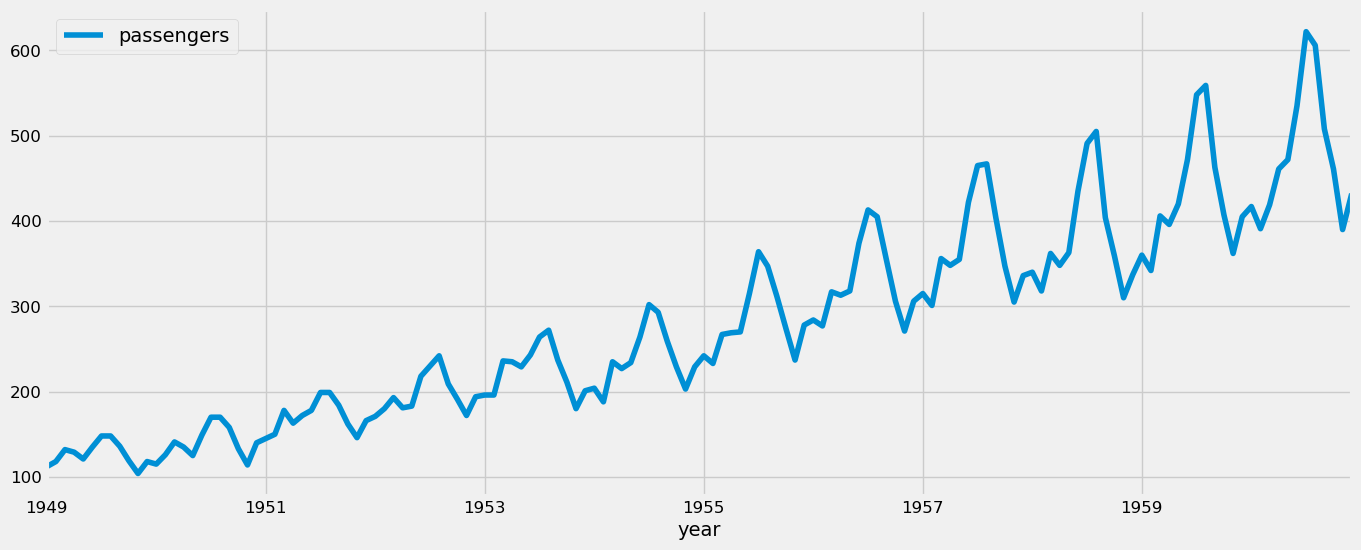

In [136]:
y.plot(figsize=(15, 6))
plt.show()

### Reviewing plots of the density of observations can provide further insight into the structure of the data:ing.

#### The distribution is not perfectly Gaussian (normal distribution).
#### The distribution is left shifted.
#### Transformations might be useful prior to modelling.

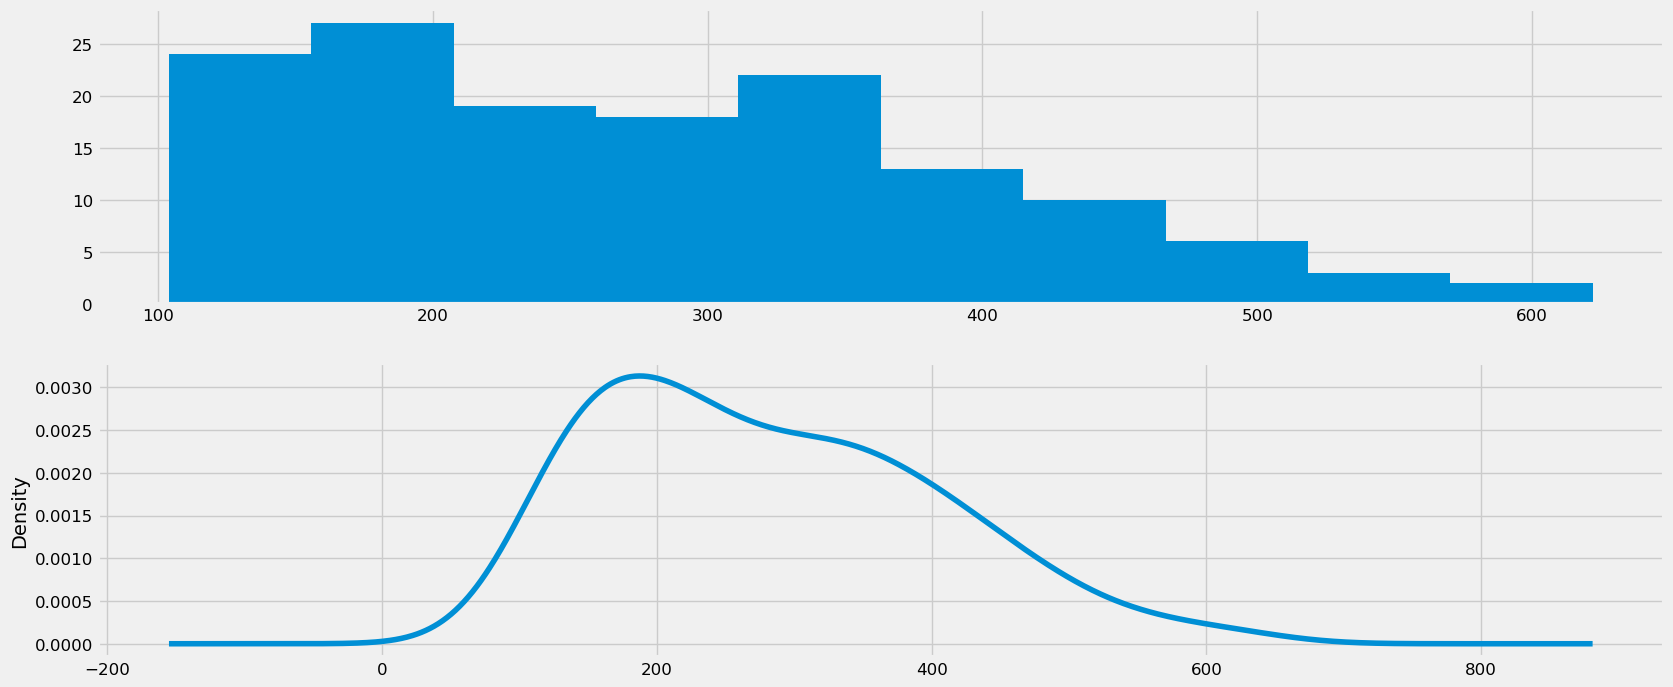

In [138]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.passengers.hist()
pyplot.subplot(212)
y.passengers.plot(kind='kde')
pyplot.show()

### Box and Whisker Plots:

#### Median values across years confirms an upwards trend
#### Steady increase in the spread, or middle 50% of the data (boxes) over time
#### A model considering seasonality might work well

<Axes: xlabel='year', ylabel='passengers'>

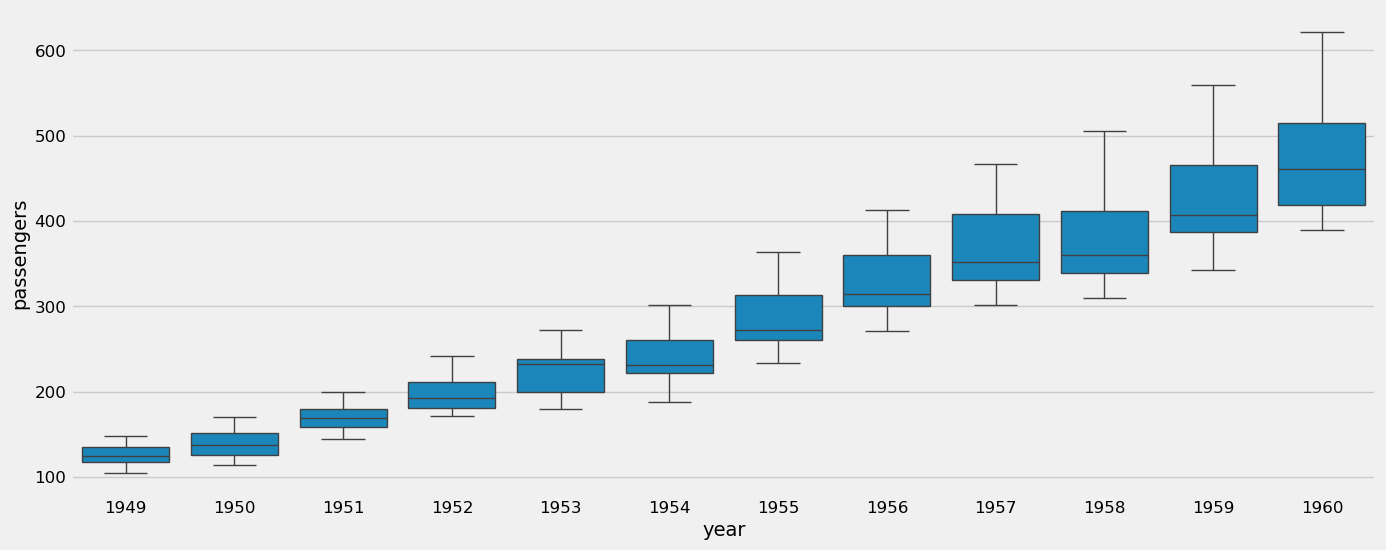

In [140]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x=y.index.year, y=y.passengers, ax=ax)

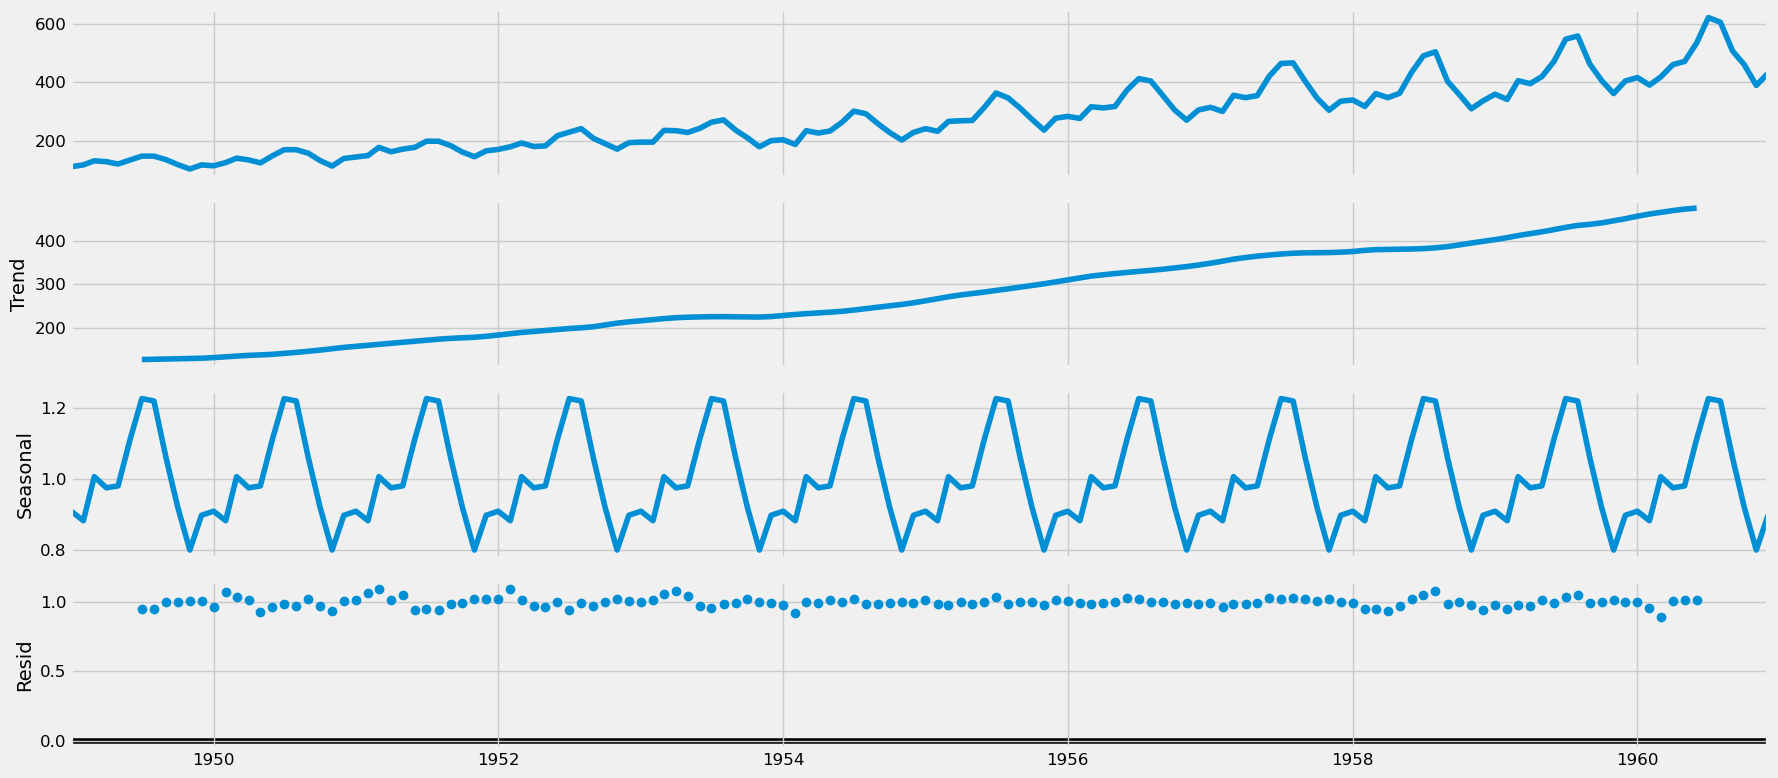

In [142]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()

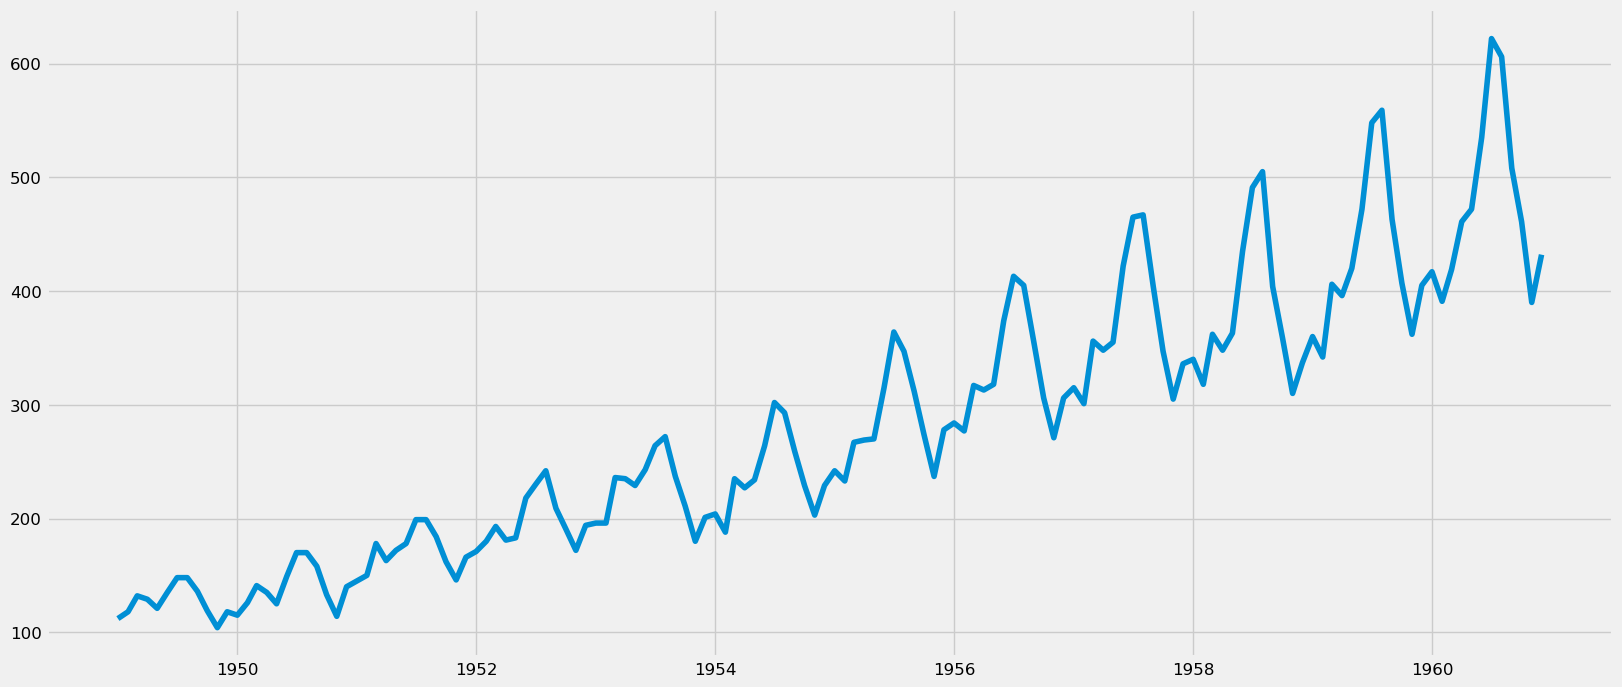

In [144]:
plt.plot(y)

## ACF and PACF plots

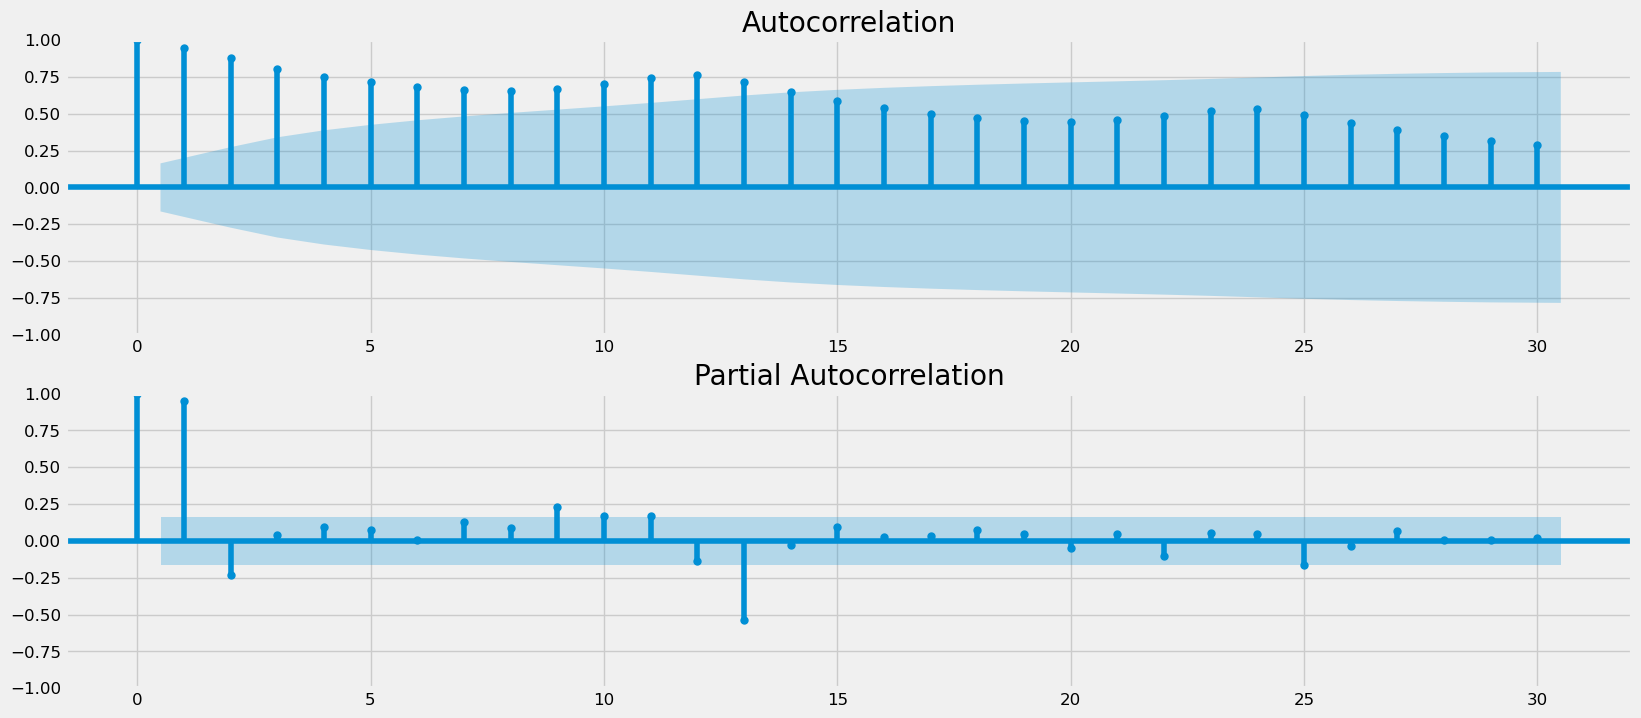

In [146]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.show()

### Rolling Statistics

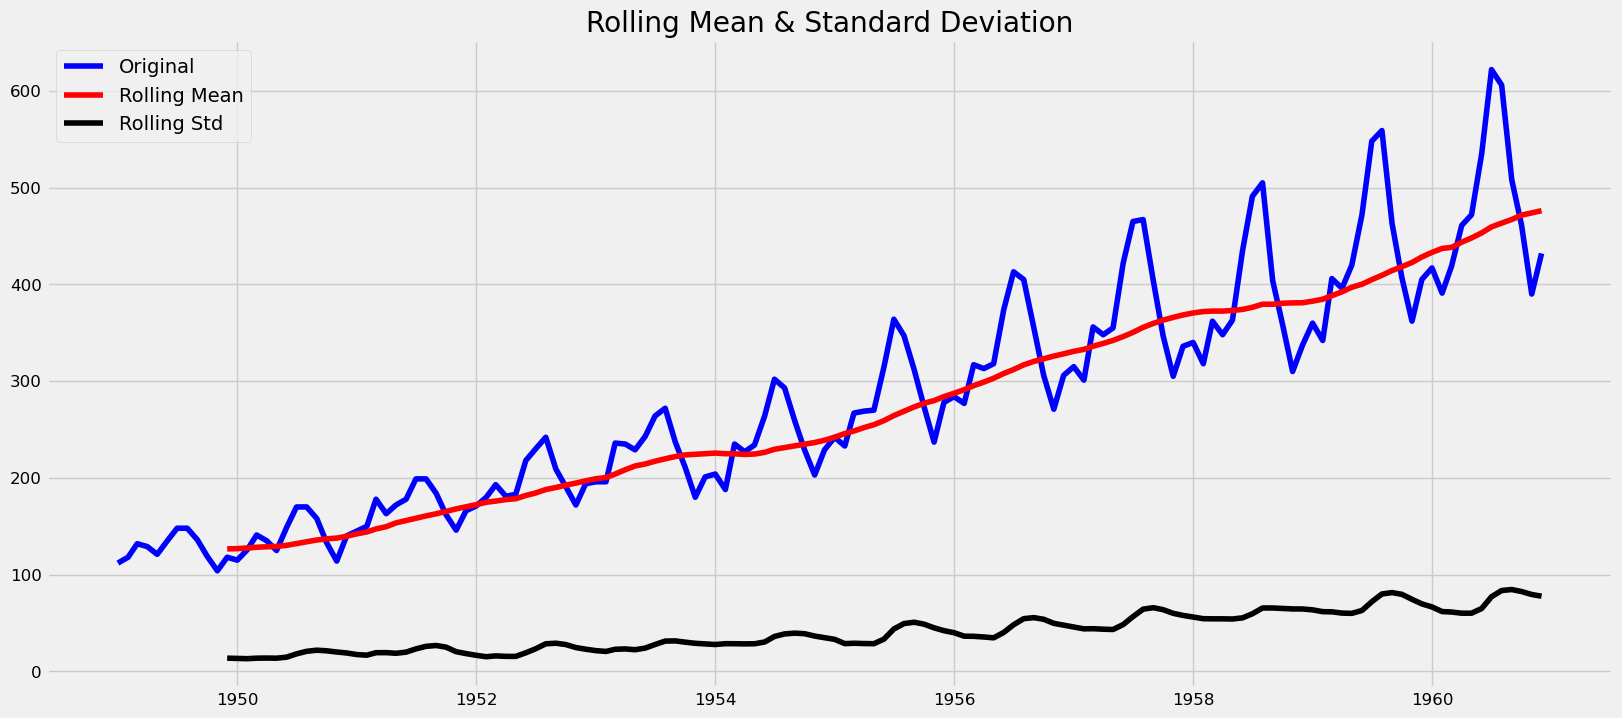

In [150]:
#Determing rolling statistics
rolmean = y.rolling(window=12).mean()
rolstd = y.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(y, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### Augmented Dickey-Fuller Test

In [154]:
from statsmodels.tsa.stattools import adfuller
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.passengers, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [174]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

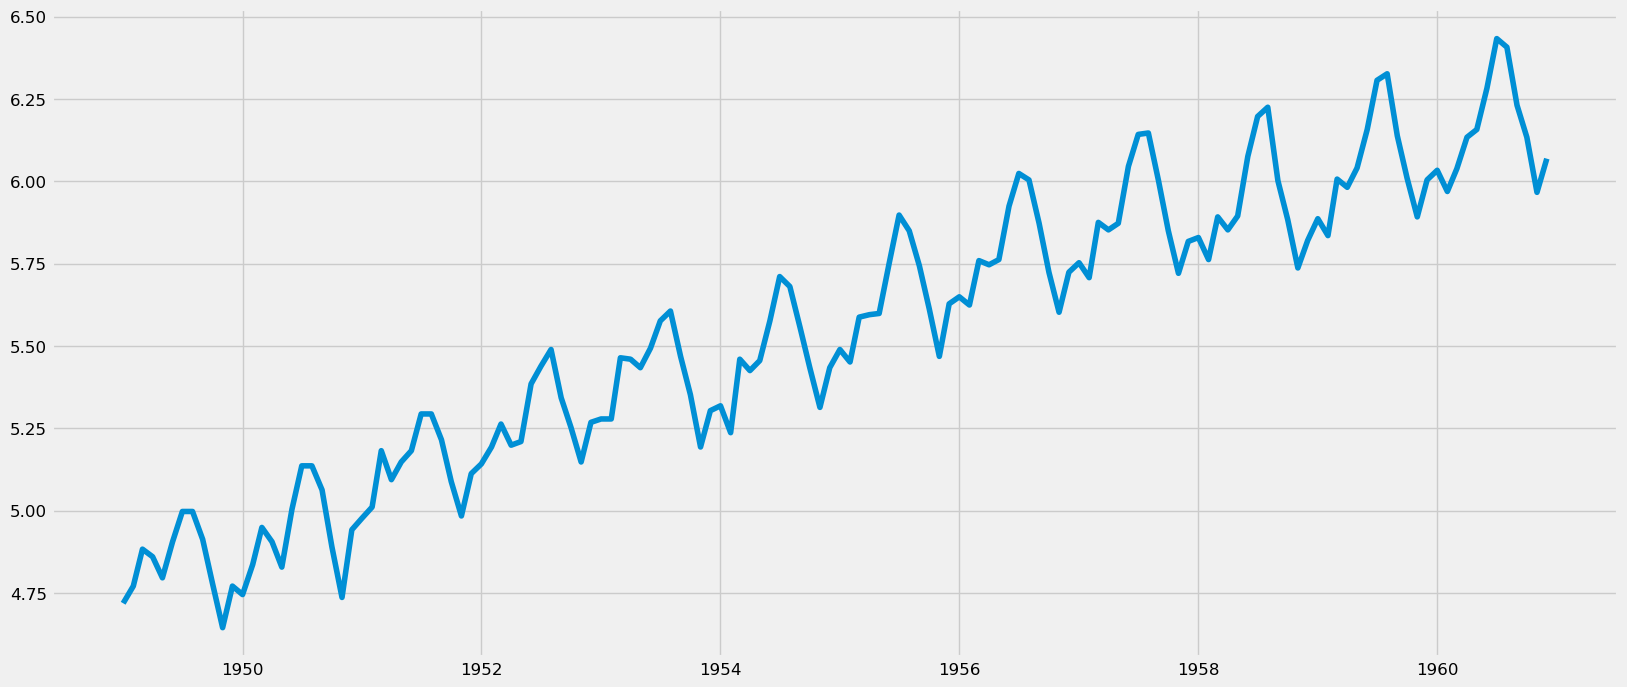

In [176]:
ts_log = np.log(y)
plt.plot(ts_log)

### Moving Average

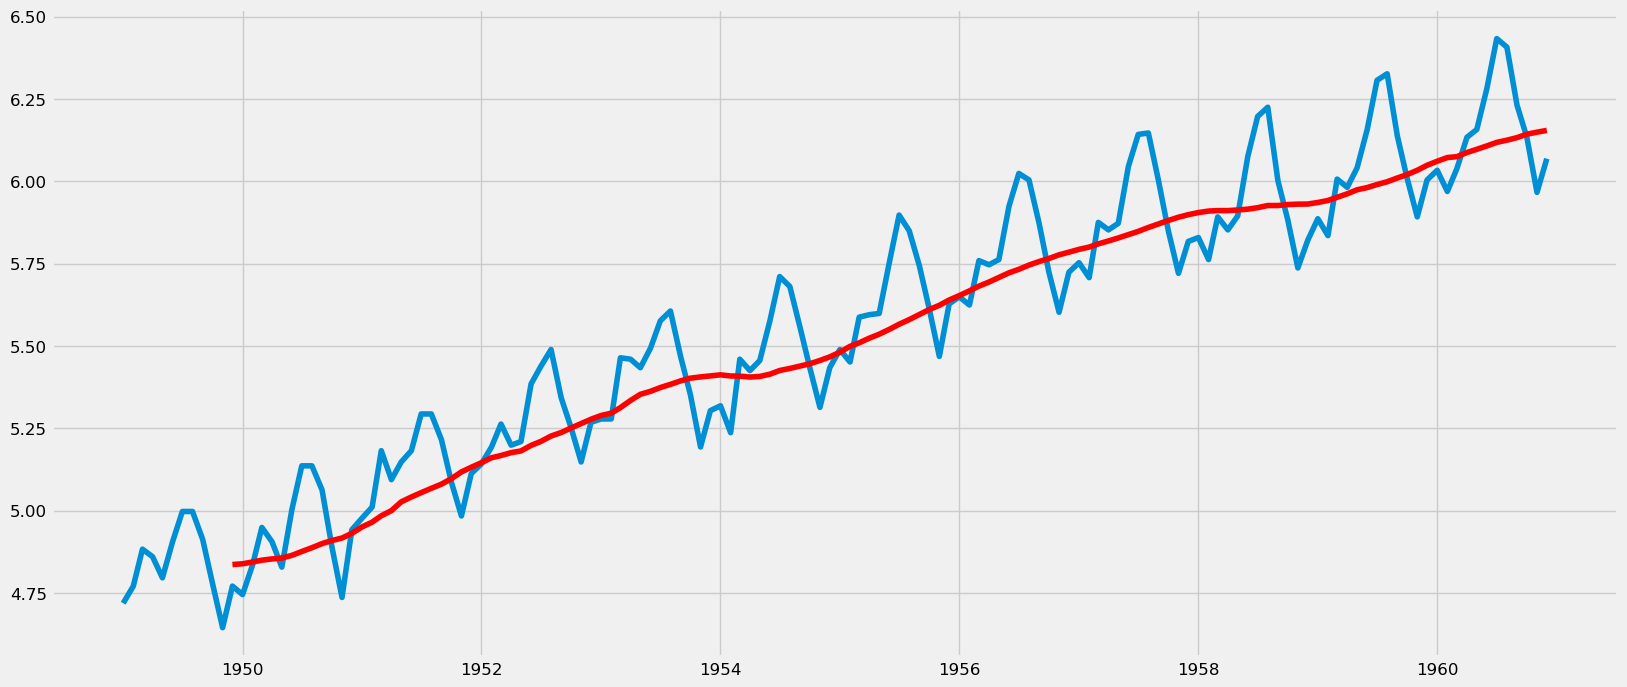

In [178]:
moving_avg = ts_log.rolling(window=12).mean()

plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [180]:
ts_log_moving_avg_diff = ts_log.passengers - moving_avg.passengers
ts_log_moving_avg_diff.head(12)

year
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: passengers, dtype: float64

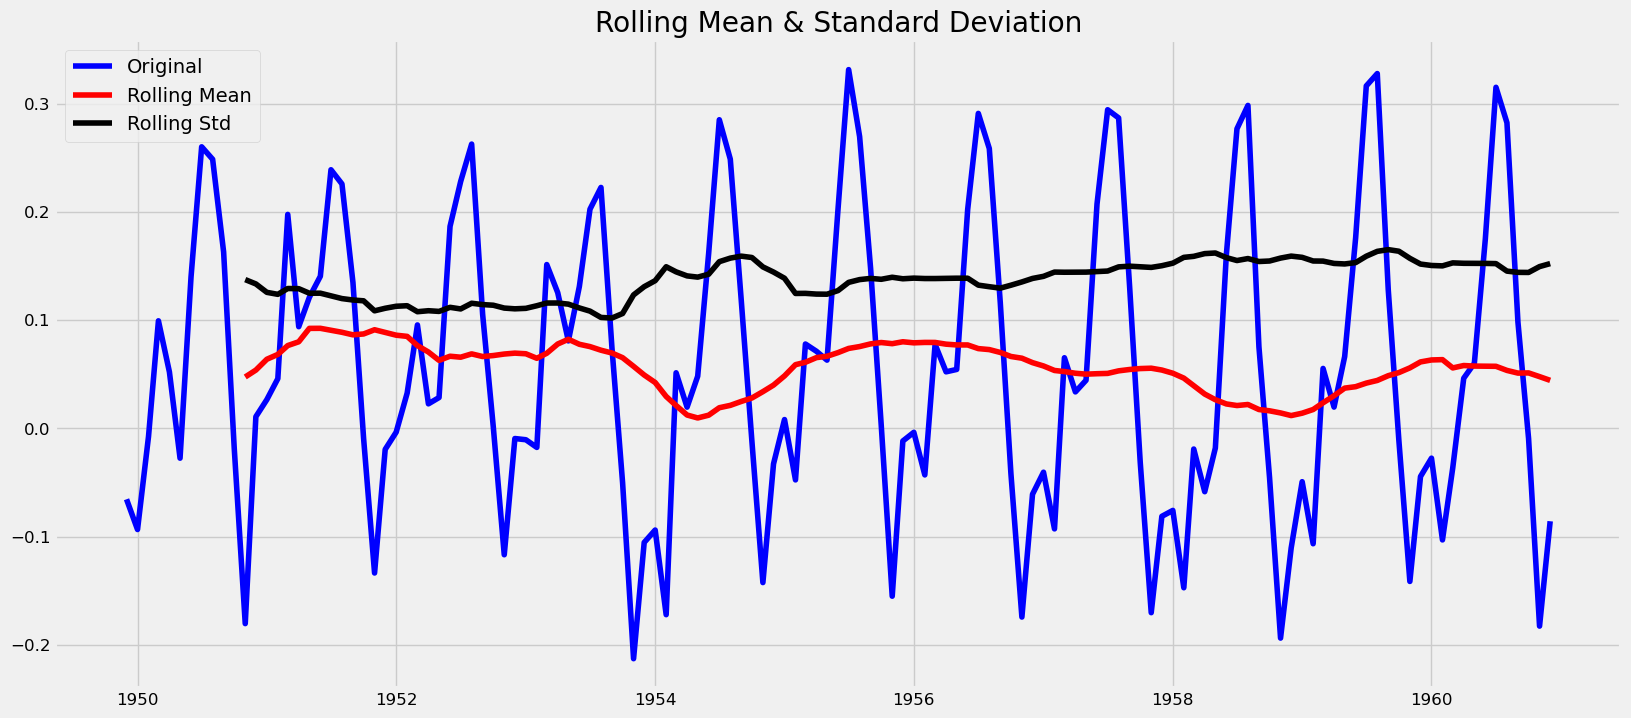

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [182]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

### Exponentially weighted moving average:

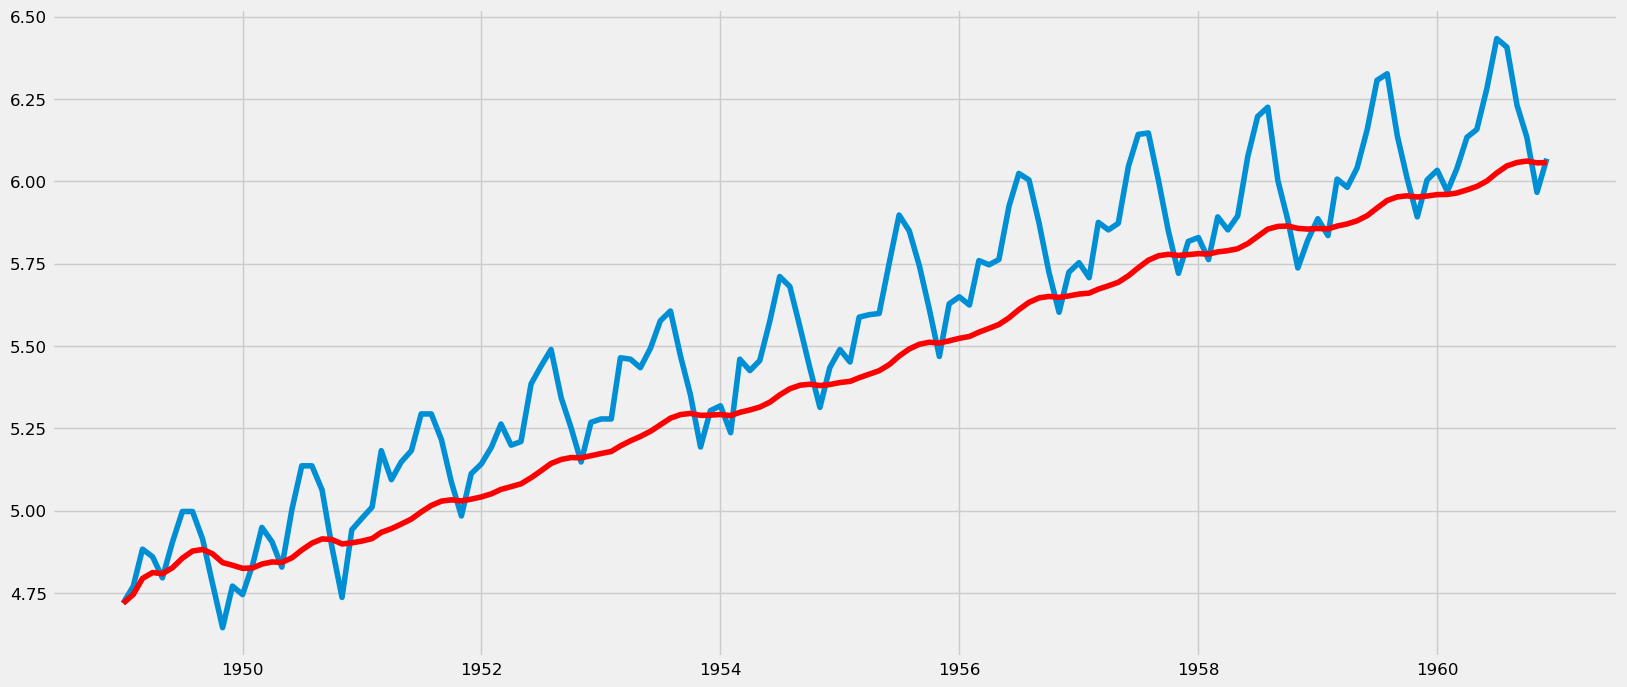

In [186]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

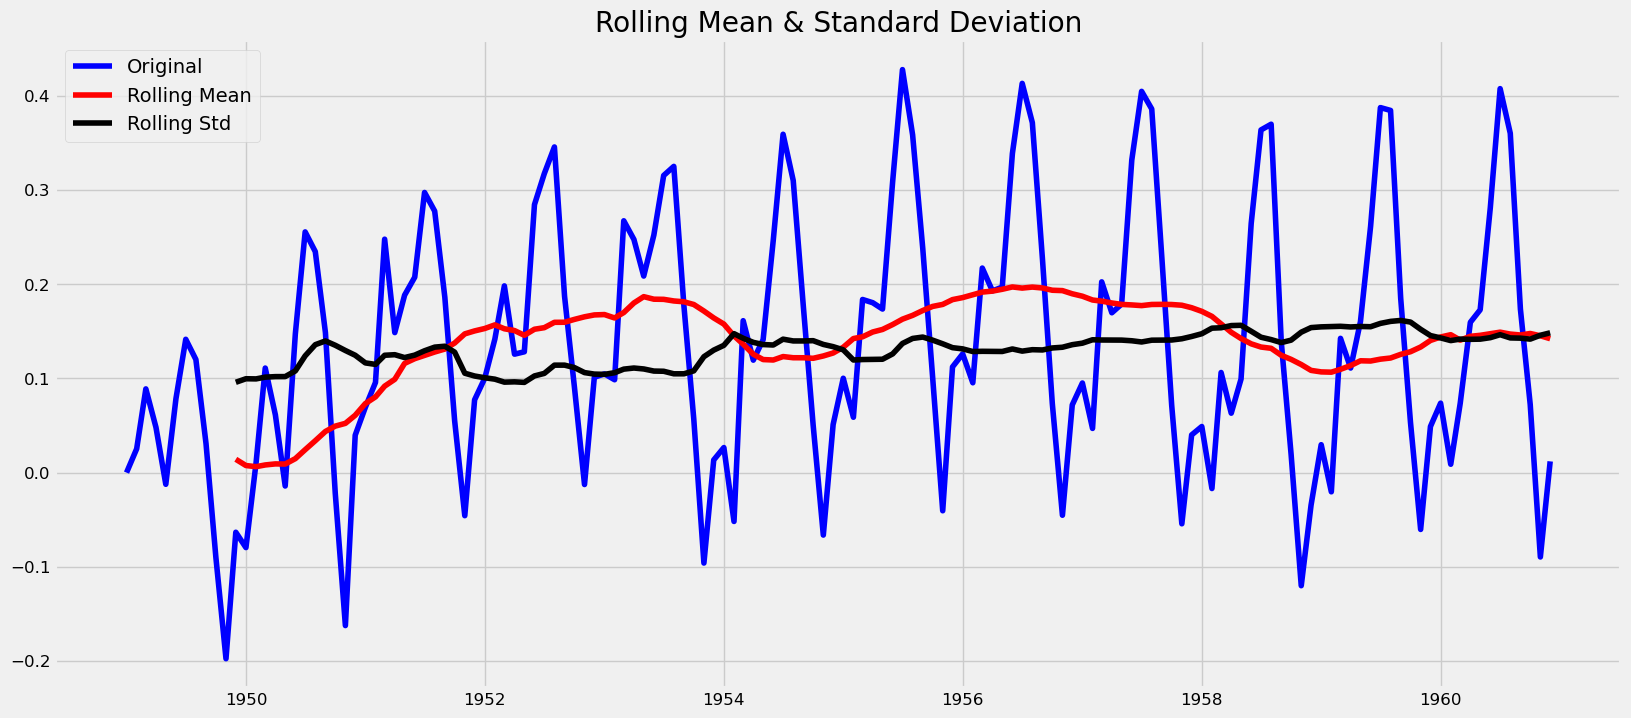

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [188]:
ts_log_ewma_diff = ts_log.passengers - expwighted_avg.passengers
test_stationarity(ts_log_ewma_diff)

### Differencing

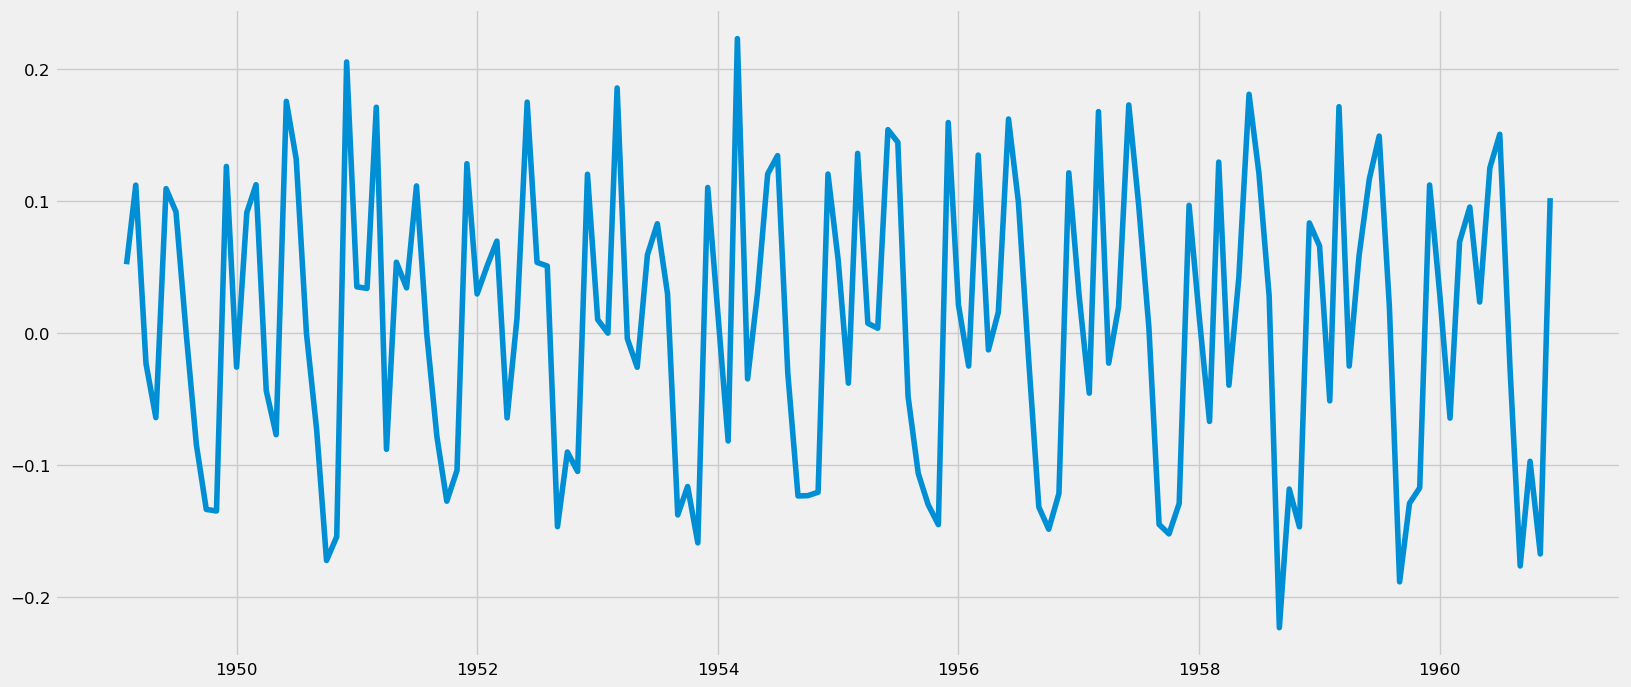

In [190]:
ts_log_diff = ts_log.passengers - ts_log.passengers.shift()
plt.plot(ts_log_diff)

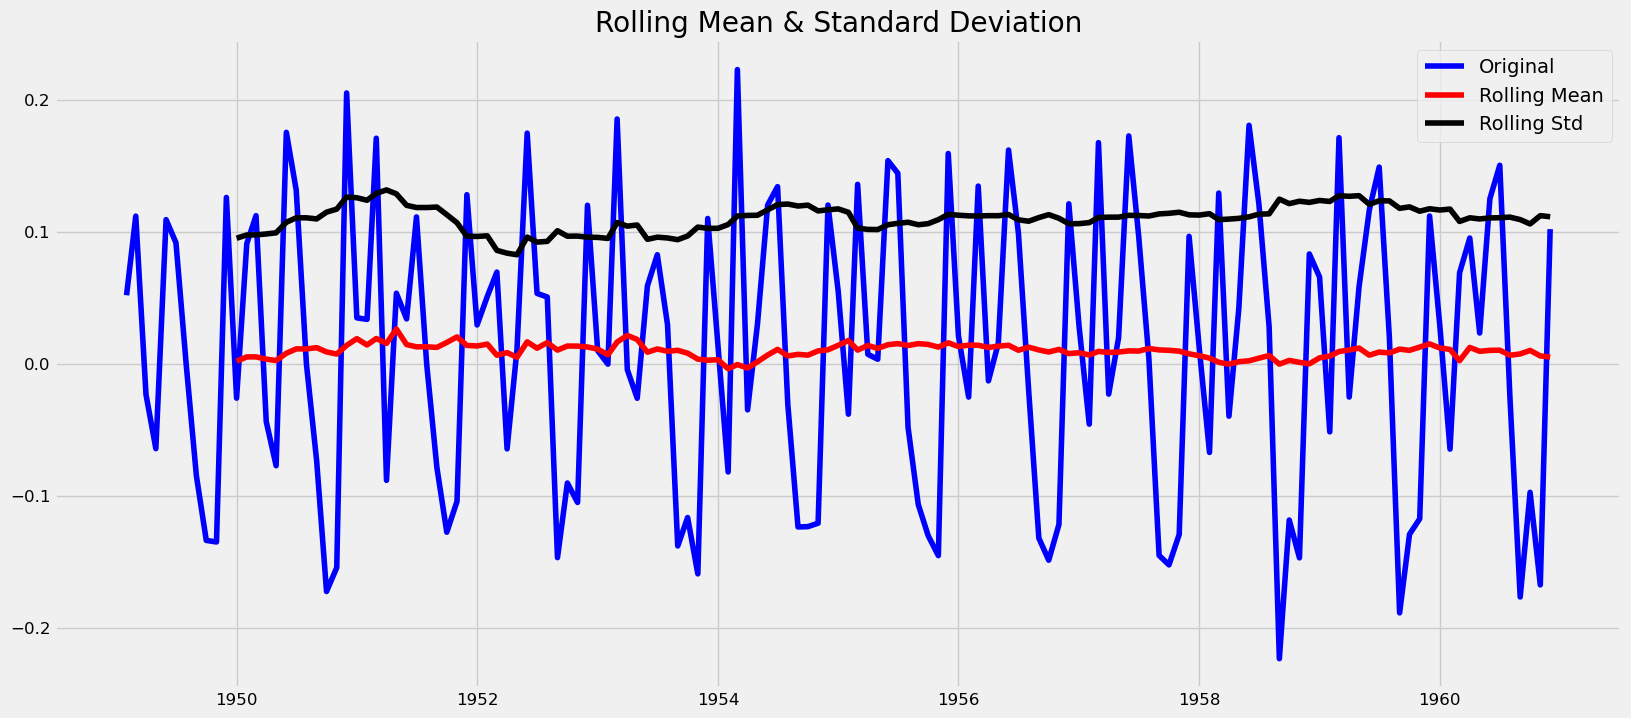

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [192]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

### Decomposition

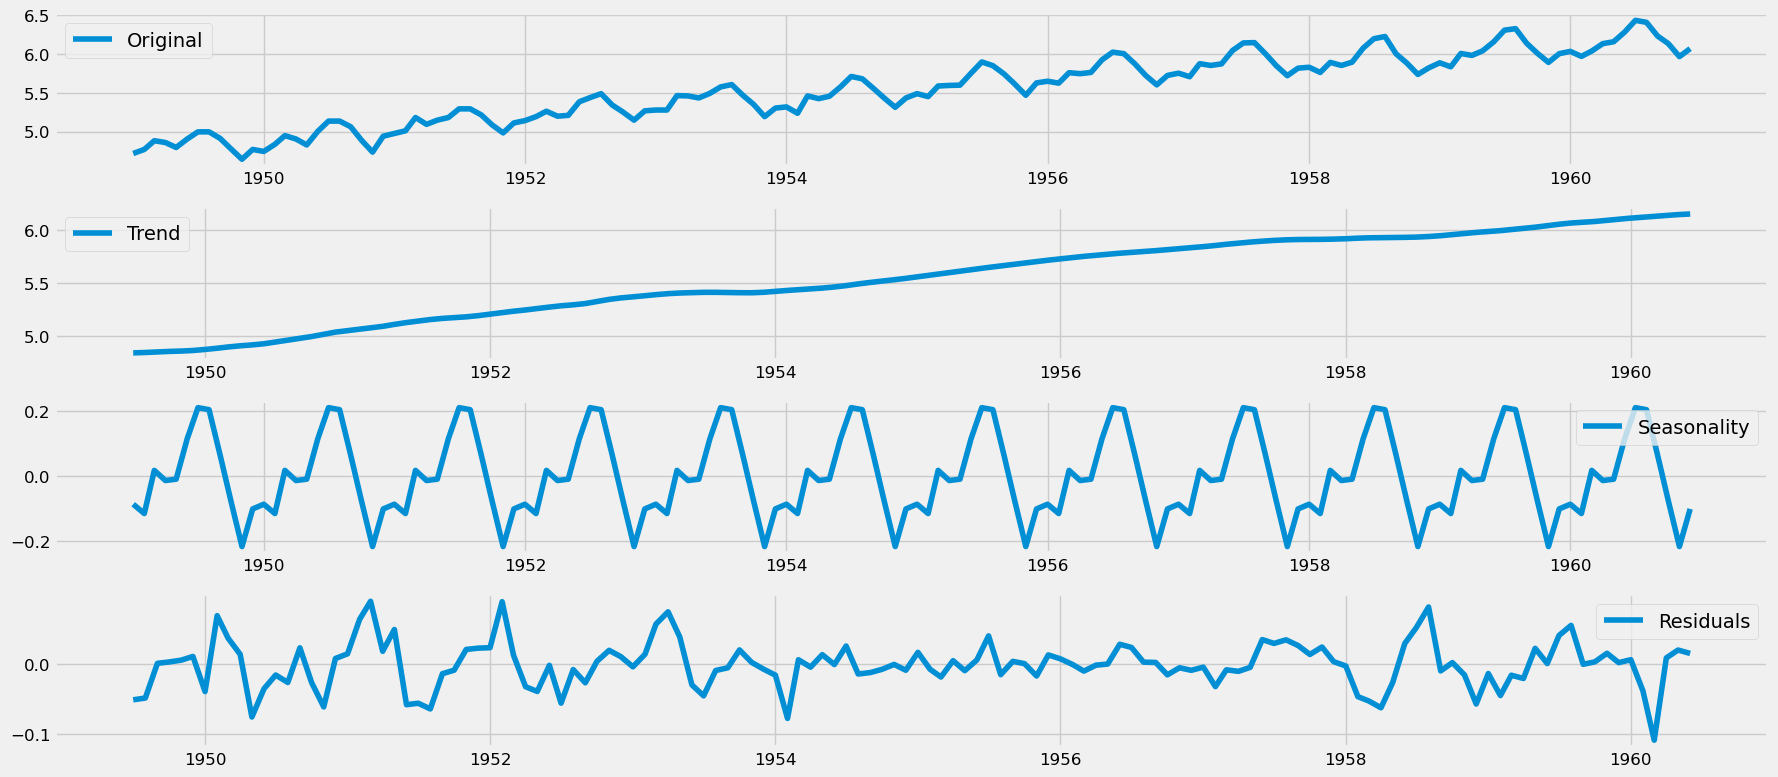

In [194]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

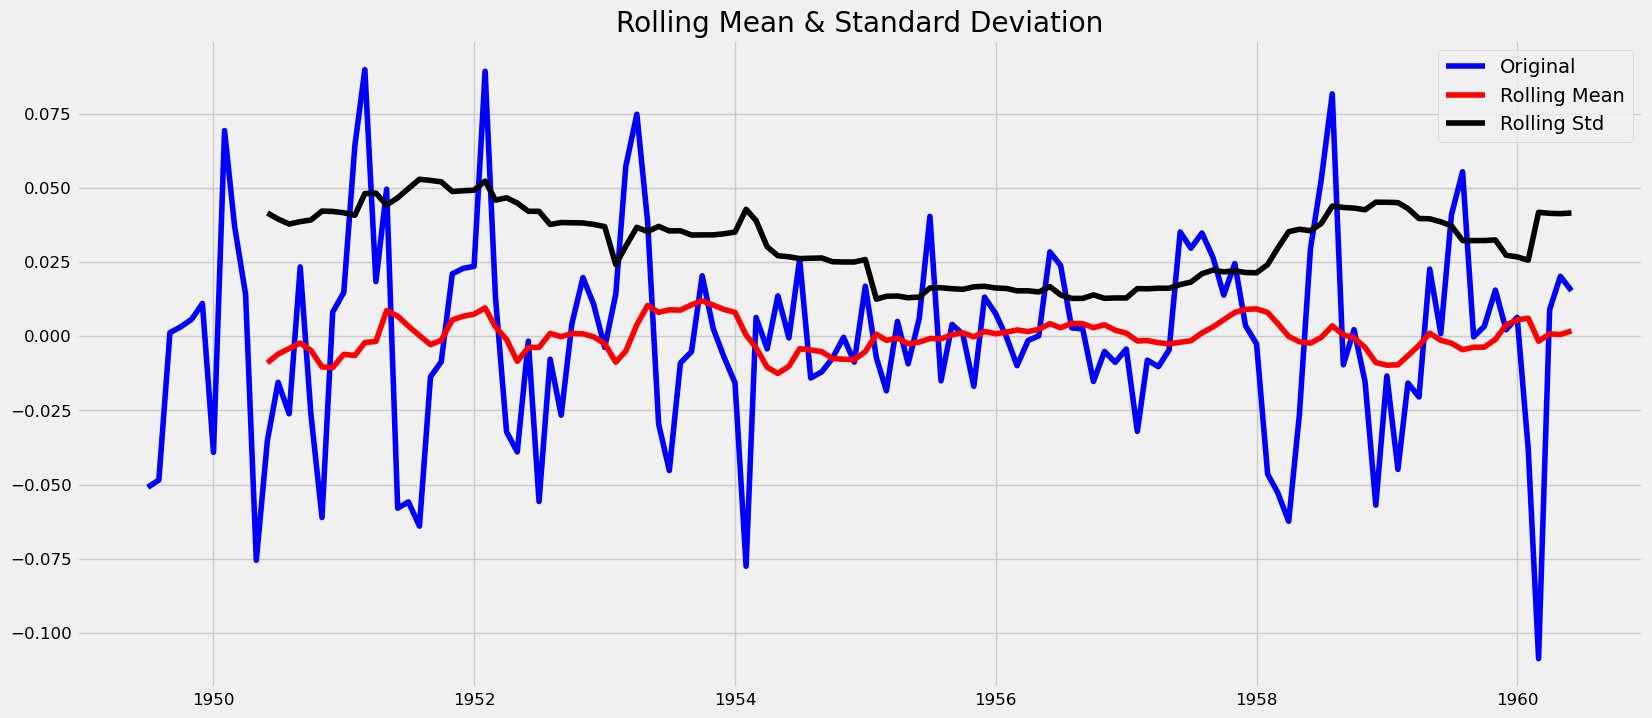

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [198]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

## Autoregression (AR)

In [237]:
from statsmodels.tsa.ar_model import AutoReg,ar_select_order
from random import random

In [239]:
# fit model
selected_lags = ar_select_order(ts_log_diff, maxlag=12, ic='aic').ar_lags

# Fit AutoReg model with selected lags
model = AutoReg(ts_log_diff, lags=selected_lags)
model_fit = model.fit()

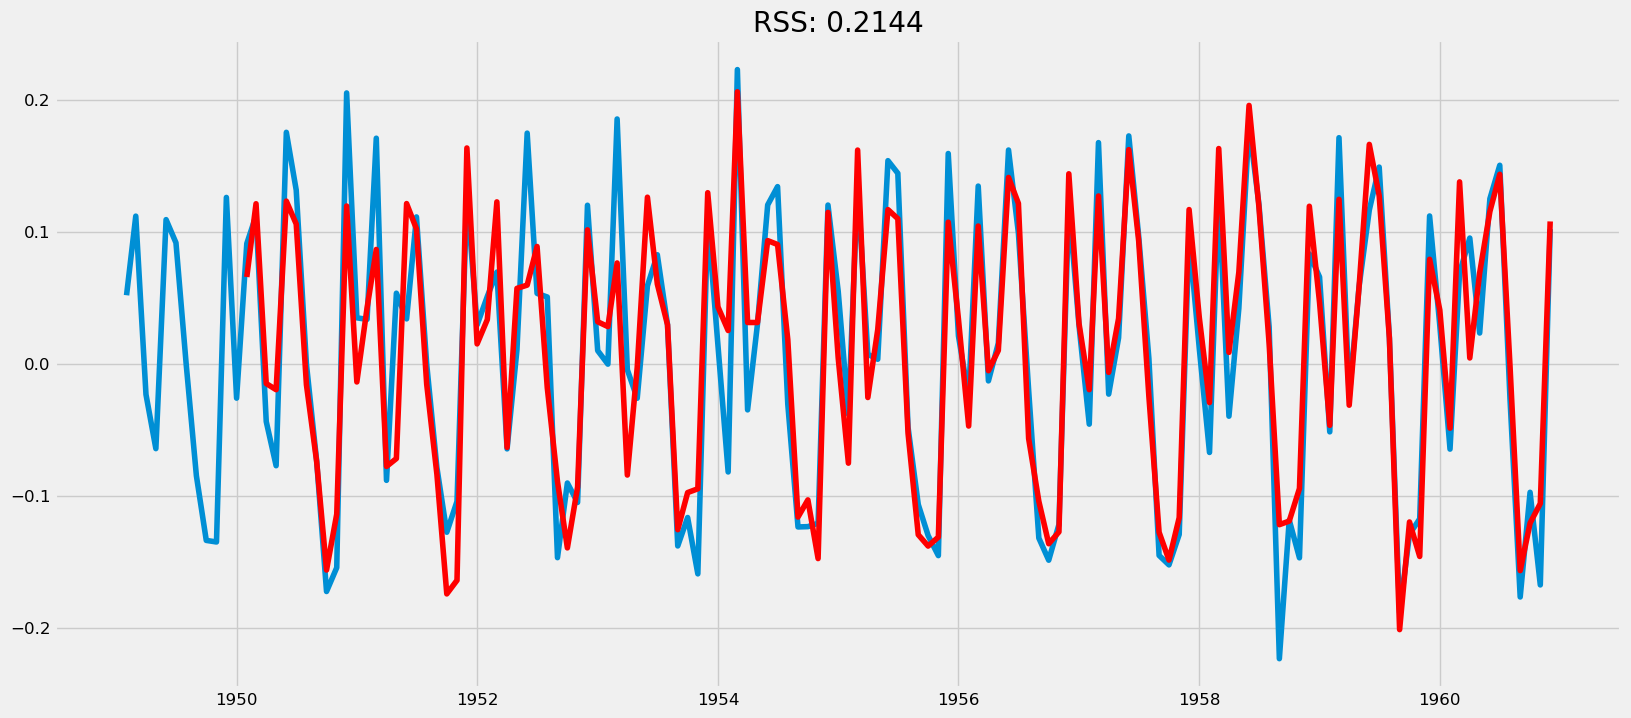

In [241]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()


## Reversing the transformations

#### Fitted or predicted values:

In [244]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

year
1950-02-01    0.066016
1950-03-01    0.121510
1950-04-01   -0.014709
1950-05-01   -0.019352
1950-06-01    0.123494
Freq: MS, dtype: float64


#### Cumulative Sum to reverse differencing:

In [246]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

year
1950-02-01    0.066016
1950-03-01    0.187525
1950-04-01    0.172816
1950-05-01    0.153465
1950-06-01    0.276958
Freq: MS, dtype: float64


#### Adding 1st month value which was previously removed while differencing:

In [248]:
predictions_ARIMA_log = pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

year
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.718499
1949-04-01    4.718499
1949-05-01    4.718499
dtype: float64

#### Taking Exponent to reverse Log Transform:

In [250]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

Text(0.5, 1.0, 'RMSE: 72.6954')

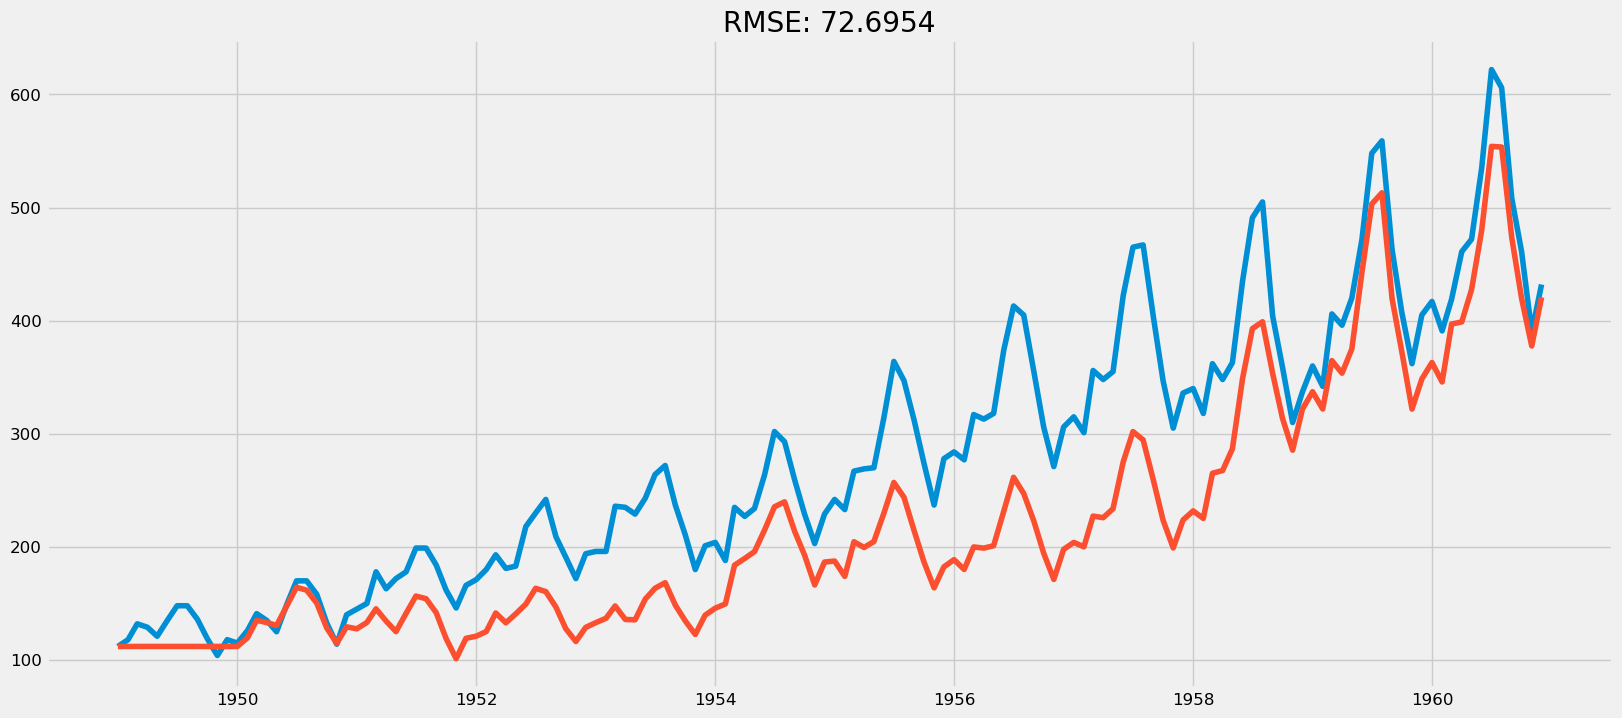

In [252]:
plt.plot(y.passengers)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA-y.passengers)**2)/len(y.passengers)))

### Forecast quality scoring metrics
R squared
Mean Absolute Error
Median Absolute Error
Mean Squared Error
Mean Squared Logarithmic Error
Mean Absolute Percentage Error

In [255]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [257]:
r2_score(y.passengers, predictions_ARIMA)

0.630238264949069

In [259]:
mean_absolute_error(y.passengers, predictions_ARIMA)

60.71244786340313

In [261]:
median_absolute_error(y.passengers, predictions_ARIMA)

52.797728081850735

In [263]:
mean_squared_error(y.passengers, predictions_ARIMA)

5284.624856321695

In [265]:
mean_squared_log_error(y.passengers, predictions_ARIMA)

0.0870549258487035

In [267]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(y.passengers, predictions_ARIMA)

21.565468026890702

### Function to evaluate forecast using above metrics:

In [270]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results
evaluate_forecast(y.passengers, predictions_ARIMA)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.630238,60.712448,52.797728,5284.624856,0.087055,21.565468,72.695425


## Autoregressive Integrated Moving Average (ARIMA)

In [285]:
ts = y.passengers - y.passengers.shift()
ts.dropna(inplace=True)

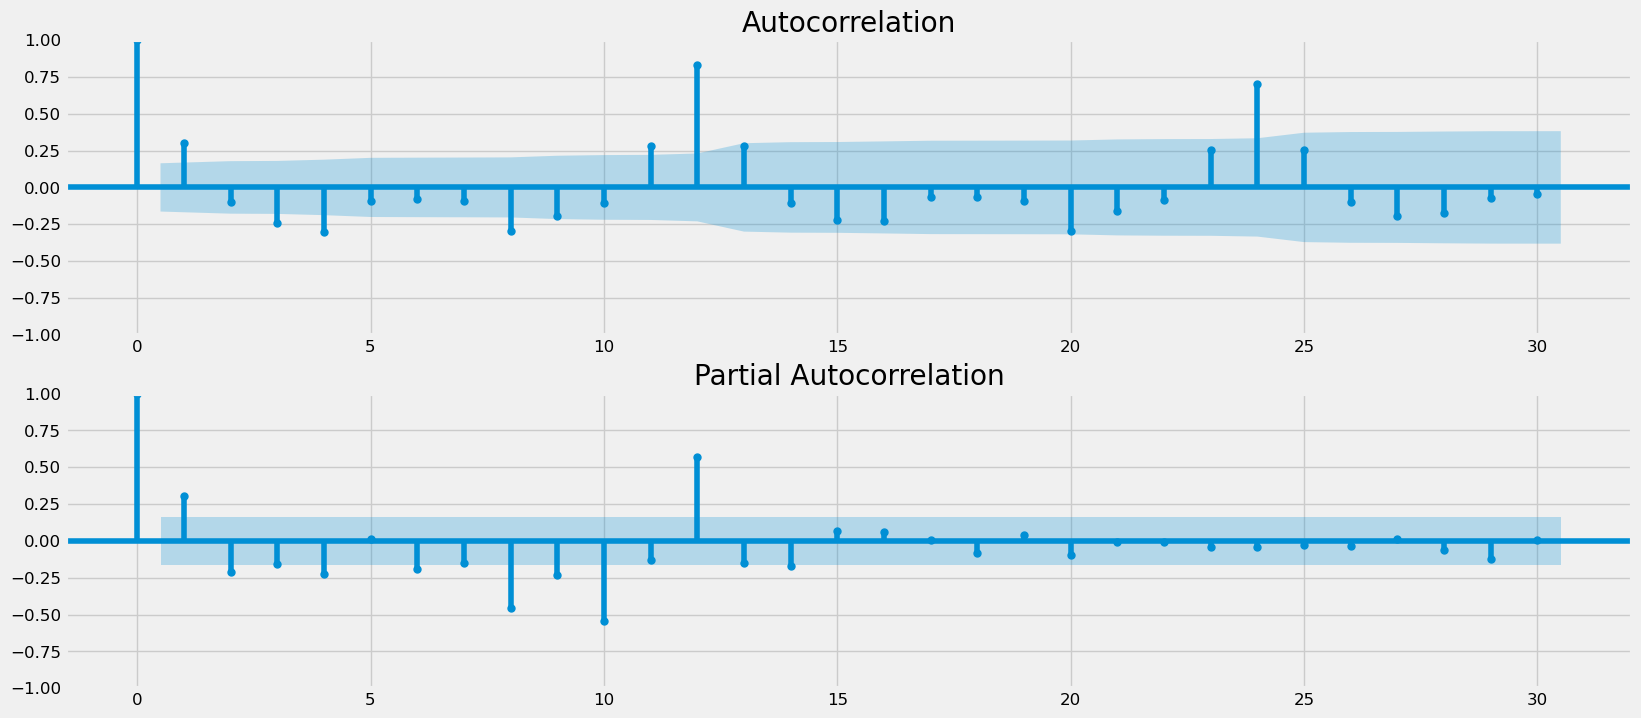

In [287]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(),lags=30)
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca(),lags=30)
pyplot.show()

<Axes: xlabel='year'>

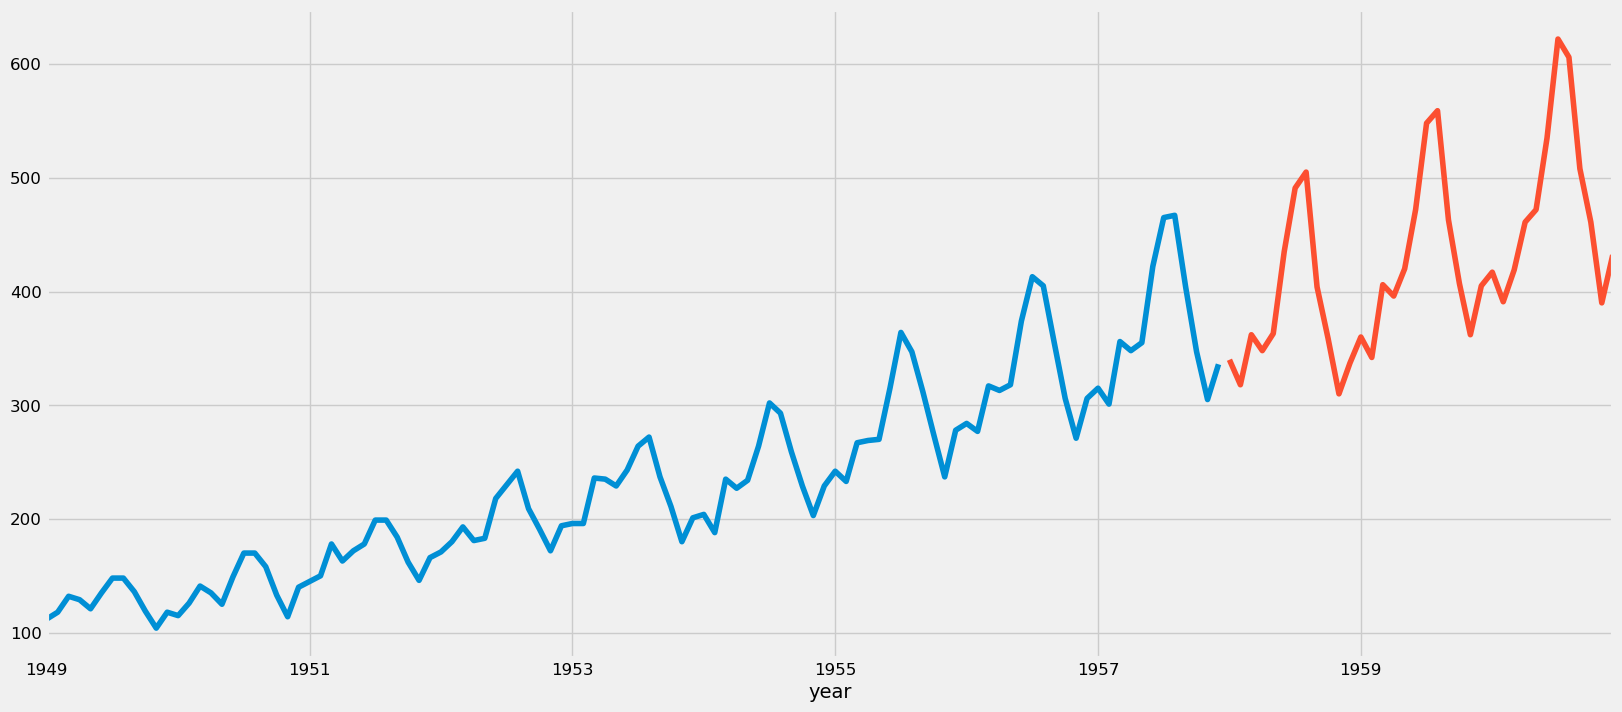

In [289]:
#divide into train and validation set
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

#plotting the data
train['passengers'].plot()
valid['passengers'].plot()


In [327]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Ensure train has a proper DateTime index with frequency
train.index = pd.to_datetime(train.index)
train = train.asfreq(train.index.inferred_freq)

# Fit ARIMA model correctly
model = ARIMA(train, order=(1, 1, 1))  # Ensure d=1 is handled inside ARIMA
model_fit = model.fit()

In [329]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             passengers   No. Observations:                  108
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -490.640
Date:                Tue, 18 Mar 2025   AIC                            987.280
Time:                        20:16:22   BIC                            995.299
Sample:                    01-01-1949   HQIC                           990.531
                         - 12-01-1957                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4856      0.136     -3.567      0.000      -0.752      -0.219
ma.L1          0.8760      0.078     11.289      0.000       0.724       1.028
sigma2       559.5788     94.858      5.899      0.000     373.661     745.496
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 1.75
Prob(Q):                              0.80   Prob(JB):                         0.42
Heteroskedasticity (H):               4.60   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [331]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)
# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 109.89878140090688, MSE:12077.742153404317


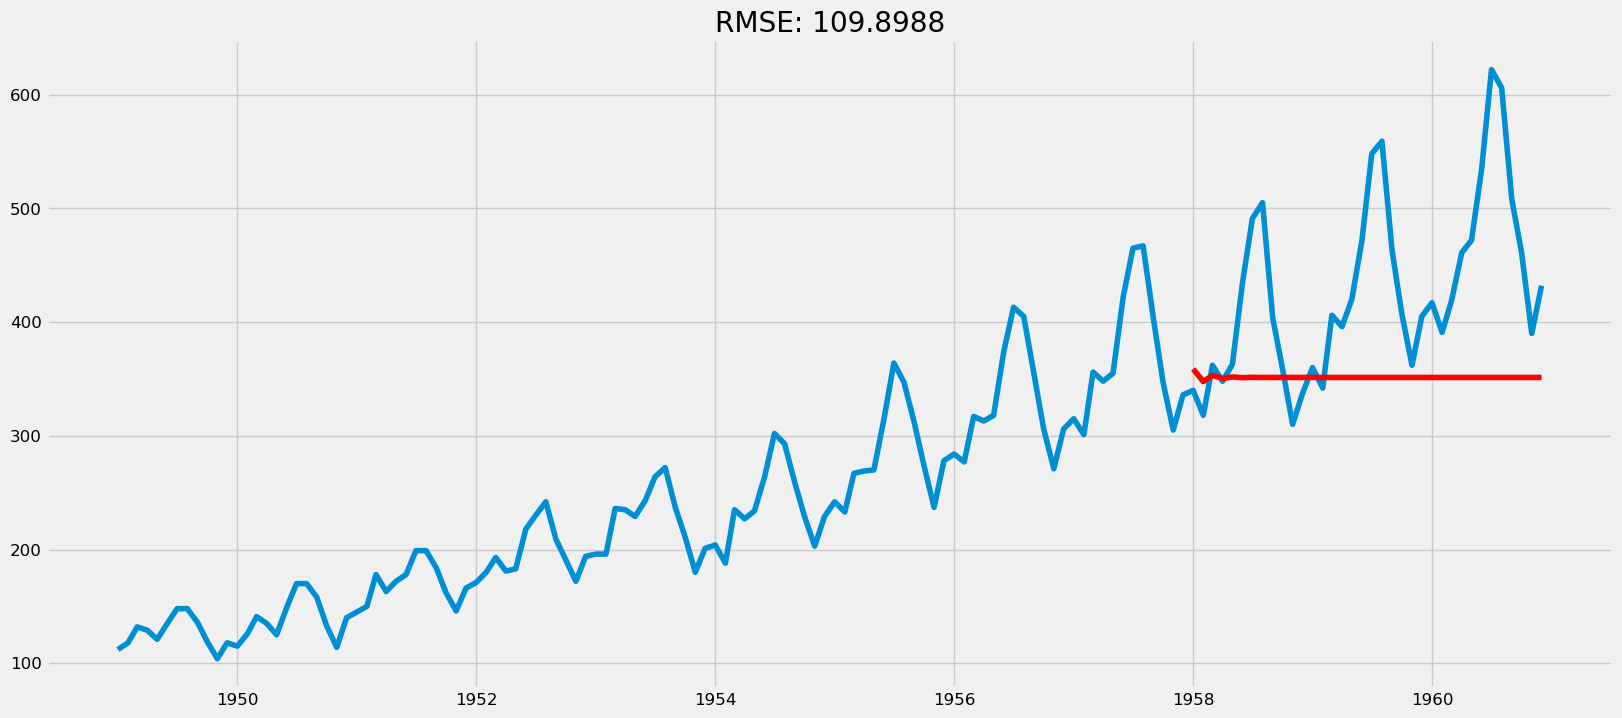

In [333]:
plt.plot(y.passengers)
plt.plot(predictions, color='red')
plt.title('RMSE: %.4f'% rmse)
plt.show()

### Fitted or predicted values:

In [335]:
predictions_ARIMA_diff = pd.Series(predictions, copy=True)
print (predictions_ARIMA_diff.head())

1958-01-01    358.724115
1958-02-01    347.689827
1958-03-01    353.047814
1958-04-01    350.446104
1958-05-01    351.709432
Freq: MS, Name: predicted_mean, dtype: float64


### Cumulative Sum to reverse differencing:

In [337]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

1958-01-01     358.724115
1958-02-01     706.413943
1958-03-01    1059.461757
1958-04-01    1409.907860
1958-05-01    1761.617292
Freq: MS, Name: predicted_mean, dtype: float64


### Adding 1st month value which was previously removed while differencing:

In [339]:
predictions_ARIMA_log = pd.Series(valid.passengers.iloc[0], index=valid.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

year
1958-01-01     698.724115
1958-02-01    1046.413943
1958-03-01    1399.461757
1958-04-01    1749.907860
1958-05-01    2101.617292
dtype: float64

### Taking Exponent to reverse Log Transform:

Text(0.5, 1.0, 'RMSE: 3891.5007')

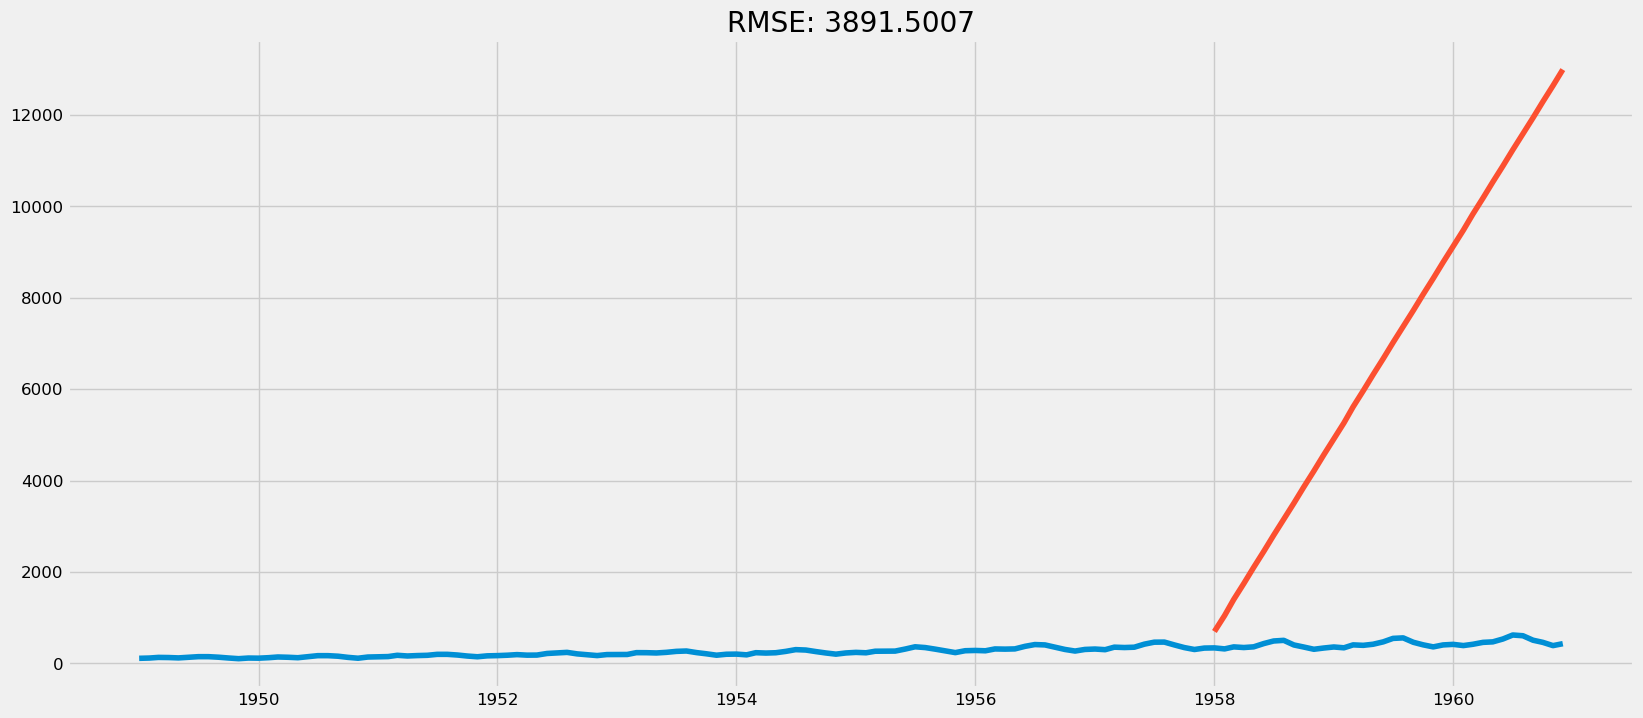

In [464]:
plt.plot(y.passengers)
plt.plot(predictions_ARIMA_log)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA_log-ts)**2)/len(ts)))

### Auto ARIMA

In [345]:
#building the model
from pmdarima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=959.218, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1002.826, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=996.373, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=991.646, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1001.531, Time=0.02 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=988.670, Time=0.39 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=983.832, Time=0.08 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 3.137 seconds


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


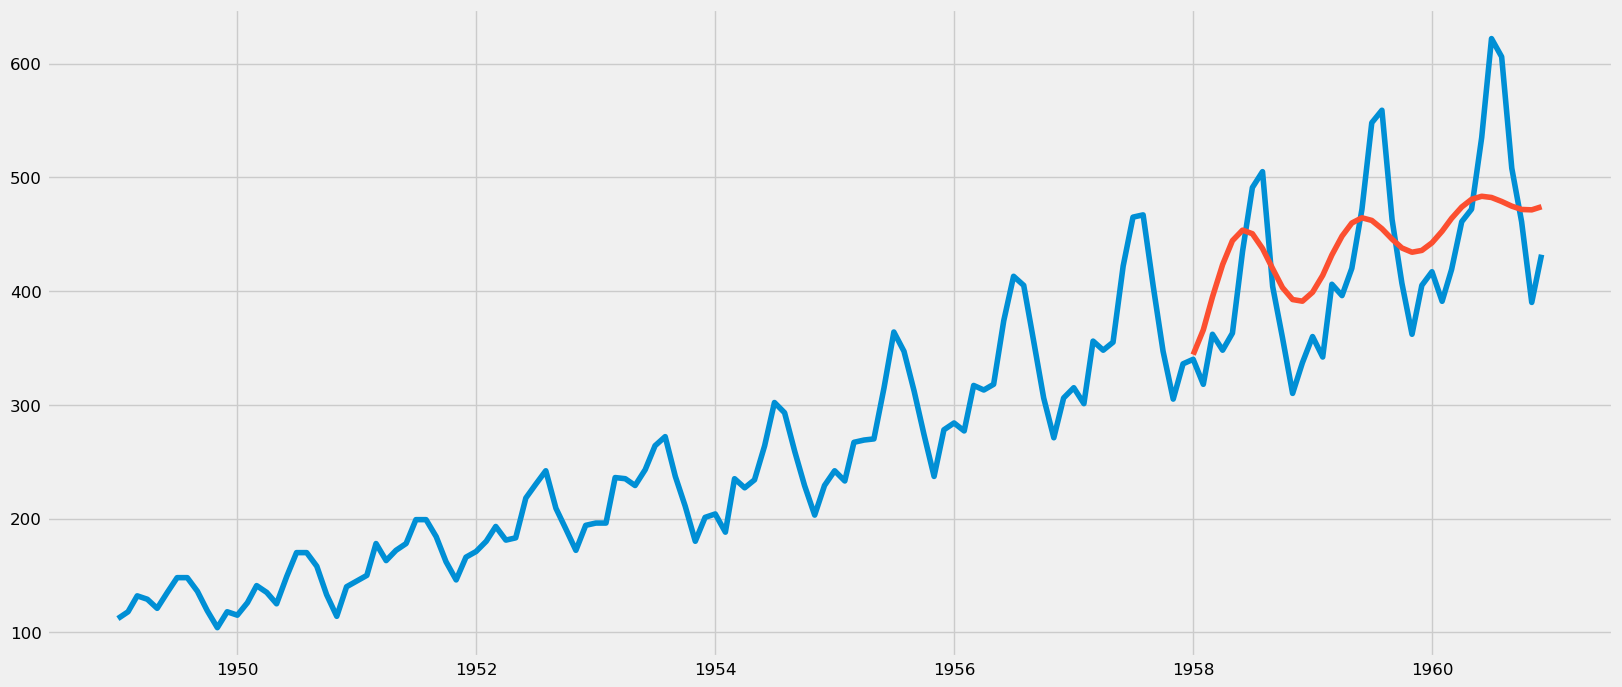

In [347]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(y.passengers, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [349]:
evaluate_forecast(valid, forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.427068,49.4883,43.100306,3505.370544,0.017613,NaN,59.20617


## Seasonal Autoregressive Integrated Moving-Average (SARIMA)

In [354]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

train.index = pd.to_datetime(train.index)
train = train.asfreq(train.index.inferred_freq)

# Fit SARIMA model (Fixing seasonal period: Example: 12 for monthly data)
model = SARIMAX(train, order=(3, 1, 3), seasonal_order=(1, 1, 1, 12))  # Seasonal period changed from 1 to 12
model_fit = model.fit()

In [356]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)
# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 23.82374966232999, MSE:567.5710479733684


Text(0.5, 1.0, 'RMSE: 23.8237')

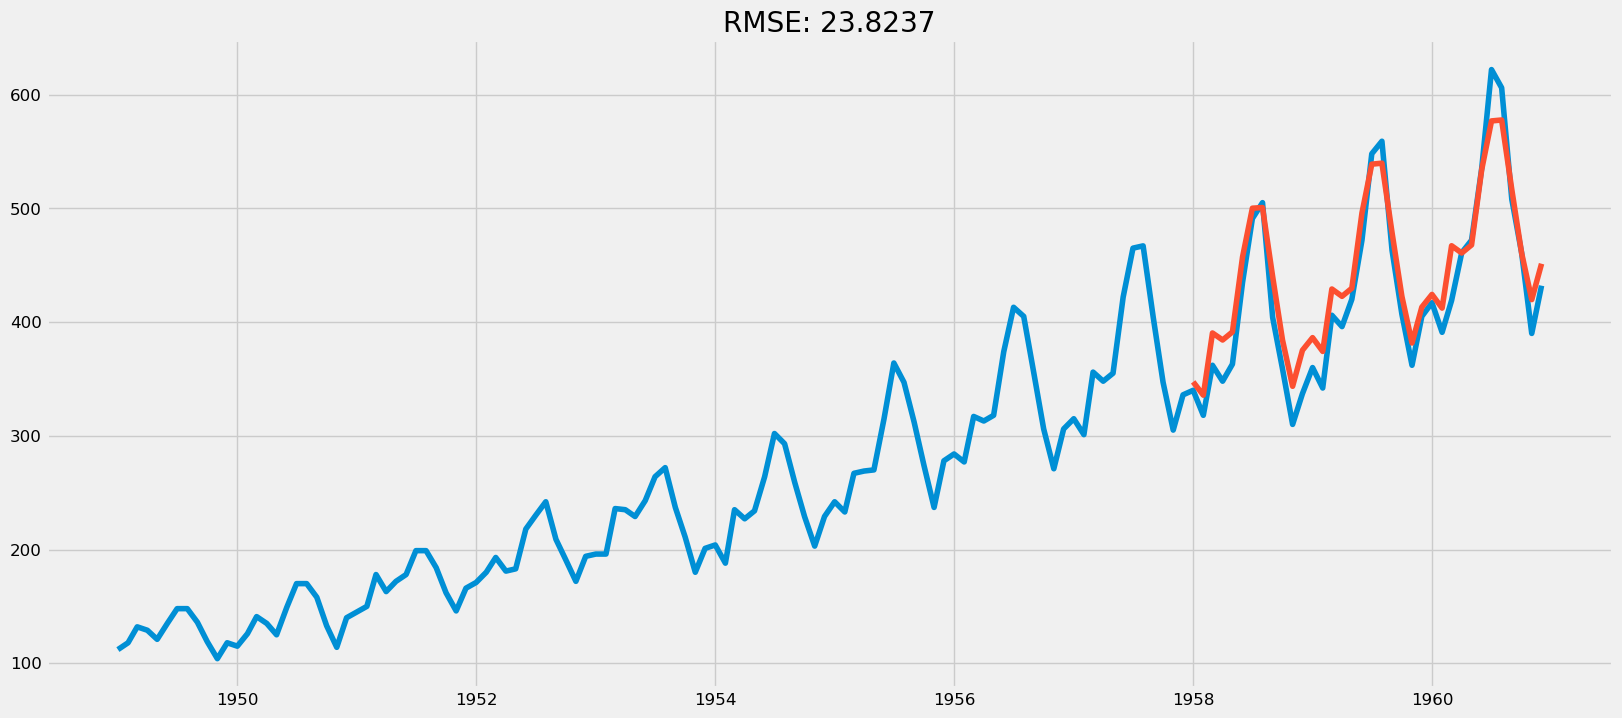

In [358]:
plt.plot(y)
plt.plot(predictions)
plt.title('RMSE: %.4f'% rmse)

In [360]:
evaluate_forecast(y[start_index:end_index], predictions)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.907234,20.255177,20.427034,567.571048,0.003385,NaN,23.82375


## Auto - SARIMA

In [380]:
#building the model
from pmdarima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=6, stepwise=True)
model.fit(train)

C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=936.762, Time=2.34 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=1002.826, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=997.166, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=993.576, Time=0.10 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[6]             : AIC=1001.531, Time=0.02 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[6] intercept   : AIC=956.753, Time=0.84 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[6] intercept   : AIC=inf, Time=0.47 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,1)[6] intercept   : AIC=inf, Time=0.86 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,2)[6] intercept   : AIC=inf, Time=1.70 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[6] intercept   : AIC=959.218, Time=0.63 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,2)[6] intercept   : AIC=907.754, Time=1.31 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,2)[6] intercept   : AIC=inf, Time=0.68 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,2)[6] intercept   : AIC=inf, Time=4.11 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,2)[6] intercept   : AIC=inf, Time=5.64 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,2)[6] intercept   : AIC=inf, Time=1.20 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,2)[6] intercept   : AIC=inf, Time=0.76 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,2)[6] intercept   : AIC=inf, Time=0.86 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,2)[6] intercept   : AIC=inf, Time=1.14 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,2)[6] intercept   : AIC=inf, Time=1.37 sec


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,2)[6]             : AIC=inf, Time=2.18 sec

Best model:  ARIMA(2,1,2)(0,0,2)[6] intercept
Total fit time: 26.401 seconds


C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(0, 0, 2, 6),
      suppress_warnings=True)

C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gokul\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


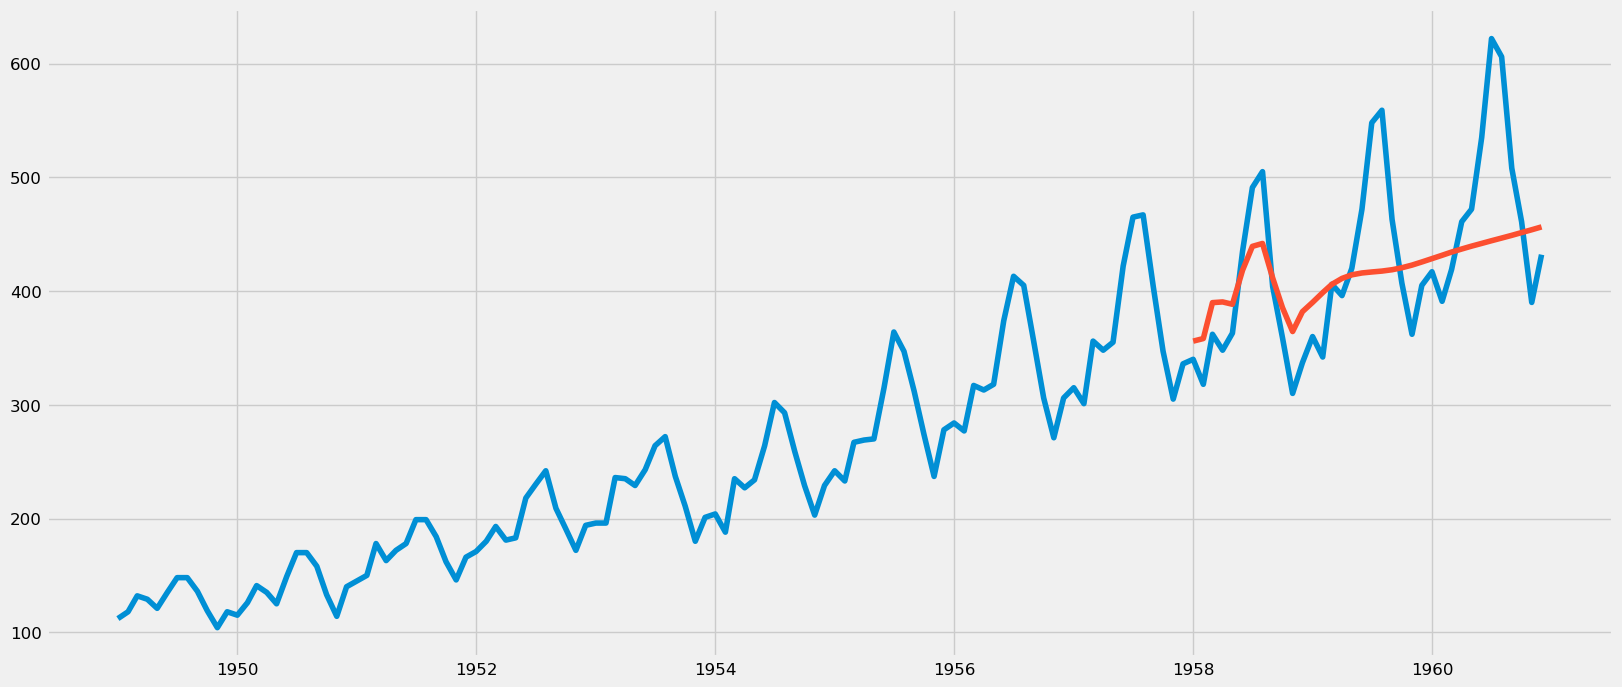

In [381]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = model.predict()
pred = model.predict(n_periods=len(valid))
pred = pd.DataFrame(pred,index = valid.index,columns=['Prediction'])
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(y.passengers, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [382]:
evaluate_forecast(y[start_index:end_index], forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.335708,47.307139,36.367314,4064.34278,0.018477,NaN,63.752198


## Tuned SARIMA

In [388]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 0, 1) x (0, 1, 0, 6)
SARIMAX: (0, 1, 0) x (0, 1, 1, 6)
SARIMAX: (0, 1, 0) x (1, 0, 0, 6)


In [390]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 6)12 - AIC:1484.6772209911371
ARIMA(0, 0, 0)x(0, 0, 1, 6)12 - AIC:1332.7081717070816
ARIMA(0, 0, 0)x(0, 1, 0, 6)12 - AIC:1106.9983169558561
ARIMA(0, 0, 0)x(0, 1, 1, 6)12 - AIC:1015.267707006778
ARIMA(0, 0, 0)x(1, 0, 0, 6)12 - AIC:1115.9461051704866
ARIMA(0, 0, 0)x(1, 0, 1, 6)12 - AIC:1001.4755946445512
ARIMA(0, 0, 0)x(1, 1, 0, 6)12 - AIC:951.095889541804
ARIMA(0, 0, 0)x(1, 1, 1, 6)12 - AIC:860.2555893602414
ARIMA(0, 0, 1)x(0, 0, 0, 6)12 - AIC:1334.2309362006279
ARIMA(0, 0, 1)x(0, 0, 1, 6)12 - AIC:1194.1257357113313
ARIMA(0, 0, 1)x(0, 1, 0, 6)12 - AIC:998.491212125711
ARIMA(0, 0, 1)x(0, 1, 1, 6)12 - AIC:912.8780689458904
ARIMA(0, 0, 1)x(1, 0, 0, 6)12 - AIC:1018.9733569845619
ARIMA(0, 0, 1)x(1, 0, 1, 6)12 - AIC:914.9884750298576
ARIMA(0, 0, 1)x(1, 1, 0, 6)12 - AIC:866.3727396780498
ARIMA(0, 0, 1)x(1, 1, 1, 6)12 - AIC:792.55202470904
ARIMA(0, 1, 0)x(0, 0, 0, 6)12 - AIC:993.1312724630138
ARIMA(0, 1, 0)x(0, 0, 1, 6)12 - AIC:943.9245123025477
ARIMA(0, 1, 0)x(0, 1, 0,

C:\Users\gokul\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(0, 1, 1, 6)12 - AIC:862.155679154505
ARIMA(1, 0, 0)x(1, 0, 0, 6)12 - AIC:954.2184484398831
ARIMA(1, 0, 0)x(1, 0, 1, 6)12 - AIC:905.0278354937973
ARIMA(1, 0, 0)x(1, 1, 0, 6)12 - AIC:707.3904075302183
ARIMA(1, 0, 0)x(1, 1, 1, 6)12 - AIC:707.4979558718159
ARIMA(1, 0, 1)x(0, 0, 0, 6)12 - AIC:983.8745153729689


C:\Users\gokul\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(0, 0, 1, 6)12 - AIC:935.5010025584747
ARIMA(1, 0, 1)x(0, 1, 0, 6)12 - AIC:976.524200916383
ARIMA(1, 0, 1)x(0, 1, 1, 6)12 - AIC:844.833173577819
ARIMA(1, 0, 1)x(1, 0, 0, 6)12 - AIC:943.501939269679
ARIMA(1, 0, 1)x(1, 0, 1, 6)12 - AIC:884.0817229036365
ARIMA(1, 0, 1)x(1, 1, 0, 6)12 - AIC:700.1612840318951
ARIMA(1, 0, 1)x(1, 1, 1, 6)12 - AIC:690.5229327756671
ARIMA(1, 1, 0)x(0, 0, 0, 6)12 - AIC:986.4207435070009
ARIMA(1, 1, 0)x(0, 0, 1, 6)12 - AIC:937.2676970230343
ARIMA(1, 1, 0)x(0, 1, 0, 6)12 - AIC:985.3821728074666
ARIMA(1, 1, 0)x(0, 1, 1, 6)12 - AIC:844.0590254404526
ARIMA(1, 1, 0)x(1, 0, 0, 6)12 - AIC:936.338864348636
ARIMA(1, 1, 0)x(1, 0, 1, 6)12 - AIC:893.6268860673304
ARIMA(1, 1, 0)x(1, 1, 0, 6)12 - AIC:692.5537522208166
ARIMA(1, 1, 0)x(1, 1, 1, 6)12 - AIC:690.3400926071563
ARIMA(1, 1, 1)x(0, 0, 0, 6)12 - AIC:970.838028710658
ARIMA(1, 1, 1)x(0, 0, 1, 6)12 - AIC:922.0887630236233
ARIMA(1, 1, 1)x(0, 1, 0, 6)12 - AIC:977.8777245169302
ARIMA(1, 1, 1)x(0, 1, 1, 6)12 - A

In [392]:
min_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        passengers   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 6)   Log Likelihood                -337.236
Date:                           Tue, 18 Mar 2025   AIC                            682.471
Time:                                   20:25:37   BIC                            692.602
Sample:                               01-01-1949   HQIC                           686.562
                                    - 12-01-1957                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4552      0.082     -5.543      0.000      -0.616      -0.294
ar.S.L6       -1.0894      0.017    -65.227      0.000      -1.122      -1.057
ma.S.L6        2.2733      0.599      3.792      0.000       1.098       3.448
sigma2        15.8309      7.949      1.992      0.046       0.252      31.410
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.95   Prob(JB):                         0.34
Heteroskedasticity (H):               0.61   Skew:                             0.37
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

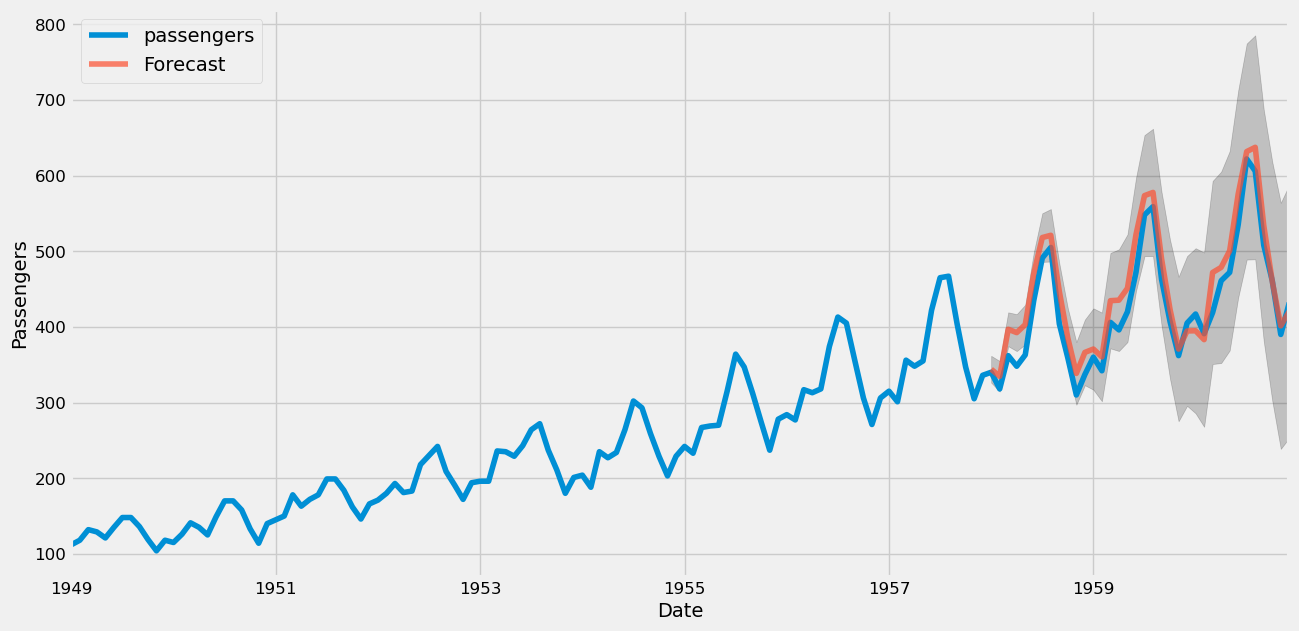

In [394]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = min_aic_model.get_prediction(start=start_index,end=end_index, dynamic=False)
pred_ci = pred.conf_int()
ax = y['1949':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

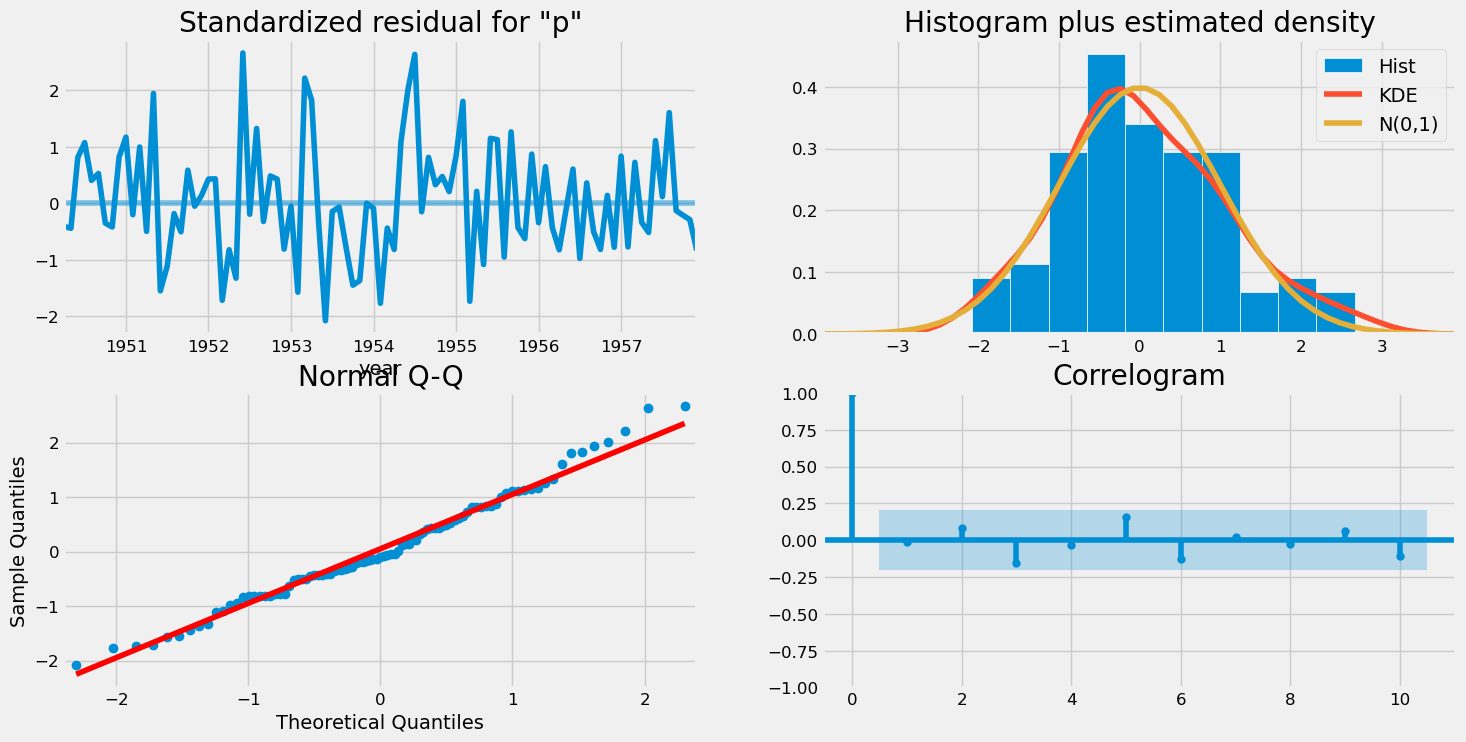

In [396]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#### The model diagnostic suggests that the model residual is normally distributed based on the following:

In the top right plot, the red KDE line follows closely with the N(0,1) line. Where, N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation of 1. This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution. Again, this is a strong indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise.

This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

In [398]:
y_forecasted = pred.predicted_mean.values
y_truth = y[start_index:end_index].passengers.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 781.54


In [400]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 27.96


In [402]:
evaluate_forecast(y_truth, y_forecasted)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.872262,24.734043,26.185792,781.542877,0.004216,5.932428,27.956088


## Prophet

In [405]:
train.head()

,passengers
year,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [407]:
train_prophet = pd.DataFrame()
train_prophet['ds'] = train.index
train_prophet['y'] = train.passengers.values
train_prophet.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [409]:
#instantiate Prophet with only yearly seasonality as our data is monthly 
model = Prophet( yearly_seasonality=True, seasonality_mode = 'multiplicative')
model.fit(train_prophet) #fit the model with your dataframe
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 36, freq = 'MS') 
future.tail()

20:27:26 - cmdstanpy - INFO - Chain [1] start processing
20:27:26 - cmdstanpy - INFO - Chain [1] done processing


,ds
139,1960-08-01
140,1960-09-01
141,1960-10-01
142,1960-11-01
143,1960-12-01


In [411]:
forecast.columns

Index(['Prediction'], dtype='object')

In [413]:
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
139,1960-08-01,618.894067,601.435008,637.954066
140,1960-09-01,536.537091,519.669659,554.592190
141,1960-10-01,468.019633,452.254949,483.473661
142,1960-11-01,414.894884,400.771999,429.469484
143,1960-12-01,461.533592,445.038353,478.505785


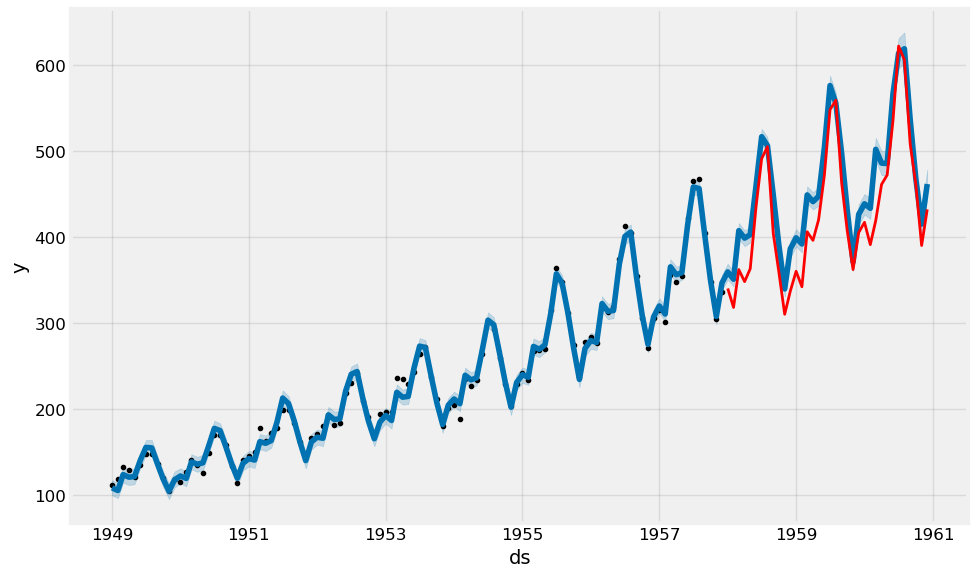

In [415]:
fig = model.plot(forecast)
#plot the predictions for validation set

plt.plot(valid, label='Valid', color = 'red', linewidth = 2)

plt.show()

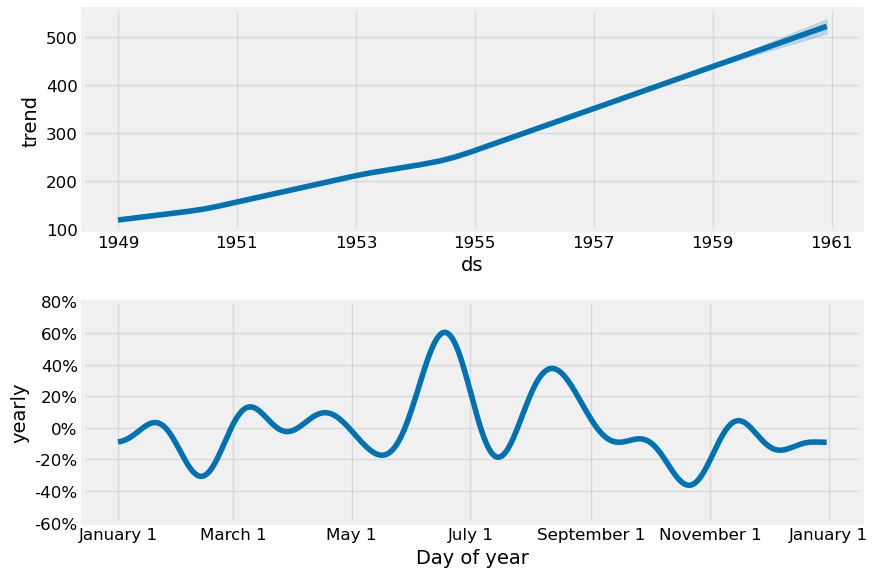

In [417]:
model.plot_components(forecast);

In [419]:
y_prophet = pd.DataFrame()
y_prophet['ds'] = y.index
y_prophet['y'] = y.passengers.values
y_prophet = y_prophet.set_index('ds')
forecast_prophet = forecast.set_index('ds')
evaluate_forecast(y_prophet.y[start_index:end_index], forecast_prophet.yhat[start_index:end_index])

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.812213,29.916177,28.996816,1148.939133,0.006736,7.497854,33.896005
